# import packages

In [1]:
import platform
import sys
os_name = platform.system()
if os_name == 'Darwin':
    sys.path.append('/Users/kperks/mnt/engram/scripts/Python/Analysis/')
if os_name == 'Linux':
    sys.path.append('/mnt/engram/scripts/Python/Analysis/')
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable

from brian2 import *
import sympy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import signal
from scipy import optimize
from scipy import stats
from scipy.stats import gaussian_kde
import pickle


import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42


# define paths

In [2]:
exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'
figure_folder = Path.cwd().resolve().parents[2] / 'engram_share' / 'GranularCellPaperResources' / 'Figure_RawEPScomponents'
df_folder = exptpath / 'data_processed' / 'Figures_GRC_properties' / 'Unsubtracted_CvsU' / 'df_cmdintact'
meta_data_folder = exptpath / 'data_processed' / 'GRC_properties_Meta'

#for storing simulation states
sim_filename = 'grc_model_initialized.pickle'
sim_filepath = Path.cwd() / 'grc_model_simulations' / sim_filename #assumes running notebook from /data_processed

# define functions

## figure styles

In [3]:
def figsave(figure_folder,figname):
    plt.savefig(figure_folder / (figname + '.pdf'),format='pdf',dpi=300, transparent = True)
    
def create_fig():
    hfig = plt.figure(figsize=[1.5,1.5])
    ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)
    return hfig,ax

def create_fig_tuning():
    figsize=[1.2,1.5]
    hfig = plt.figure(figsize = figsize) 
    ax = hfig.add_axes([0.3,0.2,0.6,0.7])
    return hfig,ax

def set_fig_style():
    rc = matplotlib.rcParams
    fontsize = 7
    rc['font.size'] = fontsize
    rc['axes.labelsize'] = fontsize
    rc['axes.titlesize'] = fontsize
    rc['axes.linewidth'] = 0.5
    rc['axes.labelpad'] = 0
    rc['font.family'] = 'sans-serif'
    rc['font.sans-serif'] = ['Helvetica','Arial','sans-serif']
    rc['xtick.major.width'] = 0.5
    rc['ytick.major.width'] = 0.5
    rc['xtick.minor.width'] = 0.5
    rc['ytick.minor.width'] = 0.5
    rc['xtick.major.size'] = 2
    rc['ytick.major.size'] = 2
    rc['xtick.minor.size'] = 2
    rc['ytick.minor.size'] = 2
    rc['xtick.major.pad'] = 0
    rc['ytick.major.pad'] = 0
    rc['xtick.minor.pad'] = 0
    rc['ytick.minor.pad'] = 0
    rc['ytick.labelsize'] = fontsize
    rc['xtick.labelsize'] = fontsize
    rc['pdf.fonttype'] = 42
    rc['ps.fonttype'] = 42
#     matplotlib.rcParams.update(rc)
    return rc

def plot_corr_matrix_multigauss(rv):
    hfig = plt.figure(figsize = (15,5))
    ax1 = hfig.add_axes([0.1,0.2,0.4,0.7])
    ax1.axis('scaled')
    ax2 = hfig.add_axes([0.5,0.2,0.4,0.7])
    ax2.axis('scaled')

    covmat = rv.covariance
    sns.heatmap(covmat,
            ax = ax1,
            annot=True,
            cbar = False,
            fmt="0.3f",
            cmap="YlGnBu",
            xticklabels=['stretch','tau','offset'],#range(np.shape(dataset)[1]),
            yticklabels=['stretch','tau','offset'])
    ax1.set_title("Covariance matrix")

    corrmat = correlation_from_covariance(covmat)
    sns.heatmap(corrmat,
            ax = ax2,
            annot=True,
            cbar = False,
            fmt="0.3f",
            cmap="YlGnBu",
            xticklabels=['stretch','tau','offset'],#range(np.shape(dataset)[1]),
            yticklabels=['stretch','tau','offset'])
    ax2.set_title("Correlation matrix")

## analyses

In [ ]:
def exp_fit(x, a, k, b):
    return a*np.exp(x*k) + b

def get_example_cmd(exptname,boutstr,sweepdur):
#     exptname = '20191218_009'
#     sweepdur = 0.05
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

#     boutstr= '[expt.get_bout_win('R','Keyboard')[0],
#             expt.get_bout_win('R','Keyboard')[1],
#             expt.get_bout_win('N','Keyboard')[0],
#             expt.get_bout_win('N','Keyboard')[1]]''
    bout = eval(boutstr)
    marker_df = expt.get_marker_table()
    dt = expt.get_dt('lowgain')
    bout_df = expt.filter_marker_df_time(marker_df,bout)

    b_df = expt.filter_marker_df_code(bout_df,['B'])
    u_df = expt.filter_marker_df_code(bout_df,['U'])

    #from uncoupled trials get times for command responses
    cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in u_df.time.values])

    xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
    cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    return xtime, cmd_

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def exclude_HighThreshAff(meta_df):
    x = np.unique(meta_df.ampshift) #array([-40,-30,-20,-10,-5,0,5,10,20,30,40])
    spk_thresh = 12

    n_excluded = 0
    n_included = 0
    expt_excluded = []

    meta_params_df = pd.DataFrame()
    colors = ['blue','orange','brown','green']
    for i,animal in enumerate(np.unique(meta_df['animalID'])):
        animal_df = meta_df[meta_df['animalID'] == animal]
        print(str(animal) + '(' + colors[i] + ')' + ' has a total of ' + str(len(np.unique(animal_df['exptname']))) + ' afferents recorded')

        params_all = []
        sse_all = []
        df_all = []

        for name in np.unique(animal_df['exptname']):
            expt_df = animal_df[animal_df['exptname'] == name]
            try:
                x_data = expt_df.dropna(0).ampshift.values
                y_data =  expt_df.dropna(0).fsl.values
                if len(np.unique(x_data)) > 5 :
                    n_included += 1
                    spk_thresh = np.max(y_data)
                    params, params_covariance = optimize.curve_fit(exp_fit, x_data, y_data, 
                                                                   p0=[1,-0.05, 3],
                                                                   bounds = ([0,-1,1],[np.inf,0,10]),
                                                                   maxfev=1000)
                    params_all.append(params)
                    c = []
                    for x_,y_ in zip(x_data,y_data):
                        yh = exp_fit(x_,params[0],params[1],params[2])
                        s = np.std(y_data[x_data==x_]) #calc std of y measure at each x to adjust chi2
                        c.append(((y_ - yh)**2))
    #                     if s==0:
    #                         c.append(((y_ - yh)**2))
    #                     if s>0:
    #                         c.append(((y_ - yh)**2)/s**2)
                    sse_all.append(np.sum(c))    
                    df_all.append(len(y_data)-3)
                if len(np.unique(x_data)) <= 5:
                    n_excluded += 1
                    expt_excluded.append(name)
                    params = array([np.NaN,np.NaN,np.NaN])
                    params_all.append(params)
                    sse_all.append(np.NaN)    
                    df_all.append(len(y_data)-3)
            except:
                n_excluded += 1
                expt_excluded.append(name)
                params = array([np.NaN,np.NaN,np.NaN])
                params_all.append(params)
                sse_all.append(np.NaN)    
                df_all.append(len(y_data)-3)
                pass # doing nothing on exception

        exptname = animal_df.groupby('exptname').exptname.describe().top.values
        max_fsl = animal_df.groupby('exptname').fsl.max().values
        a = [p[0] for p in params_all]
        k = [p[1] for p in params_all]
        b = [p[2] for p in params_all]

        meta_params = {
            'exptname' : exptname,
            'animal' : animal,
            'stretch' : a,
            'tau' : k,
            'offset' : b,
            'max_fsl' : max_fsl,
            'sse' : sse_all,
            'df' : df_all
        }
        animal_df = pd.DataFrame(meta_params)
        meta_params_df = meta_params_df.append(animal_df,sort = False,ignore_index = False)


    print('number afferents excluded because first fsl threshold too high or could not be fit: ' + str(n_excluded))
    print('number afferents included (spike thresh at least 0%): ' + str(n_included))
    # plt.ylim(1.8,15)
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    
    return meta_params_df,expt_excluded

def assess_fits(meta_params_df):
    un_fit = meta_params_df[meta_params_df['sse'].gt(meta_params_df['sse'].quantile(.9))]

    well_fit = meta_params_df[meta_params_df['sse'].lt(meta_params_df['sse'].quantile(.9))]
    plt.figure(figsize = (2,4))
    well_fit.boxplot('sse')
    
    print(un_fit)

    return well_fit,un_fit


    
def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11])
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset


## model

In [4]:
def initialize_model(namespace_sim):    
    start_scope()
    ################################################################################
    # Model definition
    ################################################################################
    IinjWav = namespace_sim['IinjWav']# TimedArray([0]*pA,dt=20*ms) #TimedArray([0,10,10,10,10,10,0]*pA,dt=20*ms) #
    invpeak = (namespace_sim['tau_e2'] / namespace_sim['tau_e1']) ** \
            (namespace_sim['tau_e1'] / (namespace_sim['tau_e2'] - namespace_sim['tau_e1']))
    namespace_sim['invpeak'] = invpeak
    ### Neurons
    neuron_eq = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_e_lmi*(E_e_lmi-v) + g_cd*(E_cd-v) + g_cd_i*(E_cd_i-v) + g_cd_lmi*(E_cd_lmi-v) + Iinj)/Cm    : volt (unless refractory)
    dg_e/dt = (invpeak * s - g_e)/tau_e1 : siemens
    ds/dt = -s/tau_e2 : siemens
    dg_e_lmi/dt = -g_e_lmi/tau_e_lmi  : siemens  # post-synaptic electrosensory inhibitory conductance
    dg_cd/dt = -g_cd/tau_cd : siemens  # post-synaptic CD excitatory conductance
    dg_cd_i/dt = -g_cd_i/tau_cd_i : siemens  # post-synaptic CD inhibitory conductance
    dg_cd_lmi/dt = -g_cd_lmi/tau_cd_lmi : siemens  # post-synaptic CD lmi-driven inhib conductance
    Iinj = IinjWav(t) : amp # injected current
    '''
        
    neurons = NeuronGroup(1, model=neuron_eq,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler',
                         name = 'grc',namespace=namespace_sim)
    neurons.v = namespace_sim['E_l']
    # set up monitor of post-synaptic neuron parameters
    state_mon = StateMonitor(neurons, ['v', 'g_e', 'g_cd','g_e_lmi','g_cd_i','g_cd_lmi','Iinj'], 
                             record=0, name = 'state_mon')
    
    ######### 
    #create and connect command input (direct and indirect via lmi)
    #########
    t_cd = array([namespace_sim['cmd_onset']])*ms
    t_cd_i = array([namespace_sim['cmd_i_onset']])*ms
    t_cd_lmi = array([namespace_sim['cmd_onset']+ namespace_sim['cmd_lmi_delay']])*ms
    G_cd = SpikeGeneratorGroup(1, array([0]), t_cd, name='jxl_input')
    G_cd_i = SpikeGeneratorGroup(1, array([0]), t_cd_i, name = 'cd_inhib_input')
    G_cd_lmi = SpikeGeneratorGroup(1, array([0]), t_cd_lmi, name = 'cd_lmi_input')
    #connect spike generator to neuron:
    syn_cd = Synapses(G_cd, neurons,on_pre='g_cd_post += w_cd',
                      name = 'jxl_syn',namespace=namespace_sim)
    syn_cd_i = Synapses(G_cd_i, neurons,on_pre='g_cd_i_post += w_cd_i',
                        name = 'cd_inhib_syn',namespace=namespace_sim)
    syn_cd_lmi = Synapses(G_cd_lmi, neurons,on_pre='g_cd_lmi_post += w_cd_lmi',
                          name = 'cd_lmi_syn',namespace=namespace_sim)
    #Now connect the synapses...
    syn_cd.connect(i=0,j=0)
    syn_cd_i.connect(i=0,j=0)
    syn_cd_lmi.connect(i=0,j=0)

    ######### 
    #create and connect afferent input (direct and indirect via lmi)
    #########
    aff_t_default = array(np.zeros(namespace_sim['N_inputs']))*ms
    N_aff = len(aff_t_default)
    neuron_ind = np.arange(N_aff)
    G_e = SpikeGeneratorGroup(N_aff, neuron_ind,aff_t_default,name='aff_input')
    G_e_lmi = SpikeGeneratorGroup(1, array([0]),array([0])*ms,name = 'aff_lmi_input')
    #connect spike generator to neuron:
    syn_e = Synapses(G_e, neurons,on_pre='s += w_e',name='aff_syn',namespace=namespace_sim)
    syn_e_lmi = Synapses(G_e_lmi, neurons,on_pre='g_e_lmi_post += \
                         w_e_lmi*(maxas+((minas-maxas)/(1+(((v-E_l)/mV)/midpt)**slp)))*nS',
                         delay=namespace_sim['e_lmi_delay']*ms,
                      name='aff_lmi_syn',namespace=namespace_sim)

    #Now connect the synapses...
    syn_e.connect(i=neuron_ind, j = 0)
    syn_e_lmi.connect(i=0, j = 0)

    net = Network(collect())
    return net, namespace_sim


def reset_namespace_defaults():
    namespace_sim = {
        'N_inputs' : 1,
        'N_runs' : 1,
        'sim_dt' : 0.1*ms,
        'duration' : 0.05*second,
        'Cm' : 12*pF,
        'E_l' : -70*mV,
        'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
        'E_e' : 0*mV,
        'E_cd' : 0*mV,
        'E_cd_i' : -80*mV,
        'E_cd_lmi' : -80*mV,
        'E_e_lmi' : -80*mV,
        'V_th' : 0*mV,
        'V_r' : -70*mV,
        'tau_r' : 1*ms,
        'w_e' : 0*nS,
        'w_e_lmi' : 0,#either on and off... weight by logistic 0*nS,
        'w_cd' : 0*nS,
        'w_cd_i' : 0*nS,
        'w_cd_lmi' : 0*nS,  
        'tau_e1' : 4*ms,
        'tau_e2' : 1*ms,
        'tau_e_lmi' : 10*ms,
        'tau_cd' : 2*ms,
        'tau_cd_i' : 5*ms,
        'tau_cd_lmi' : 5*ms,
        'cmd_onset' : 5, #ms
        'cmd_i_onset' : 4.5,
        'cmd_lmi_delay' : 4, #ms
        'aff_cmd_offset' : 5, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5, #ms, time of normal stimulus onset relative to cmd
        'e_lmi_delay' : 2, #ms
        'IinjWav' : TimedArray([0]*pA,dt=20*ms),
        'invpeak' : 1
        'maxas' : 3.5 #dgc
        'minas' : 0 #dgc
        'midpt' : 2 #dgc
        'slp' : 3 #dgc
    }
    return namespace_sim

def generate_y_fit(x,n_inputs,dataset,rv):
    #generate y_fit array on each iteration
    stretch_min = np.min(dataset[:,0])
    stretch_max = np.max(dataset[:,0])
    tau_min = np.min(dataset[:,1])
    tau_max = np.max(dataset[:,1])
    offset_min = np.min(dataset[:,2])
    offset_max = np.max(dataset[:,2])
#     max_fsl = np.max(dataset[:,3])
    max_fsl = 12
    

    # hfig = plt.figure(figsize=(3,4))
    # ax1 = hfig.add_axes([0.1,0.1,0.8,0.8])
#     x = array([-40,-30,-20,-10,-5,0,5,10,20,30,40])
    i = 0
    y_fit = []
    while i <n_inputs:
        [s,t,o] = rv.resample(1)
        while (s<stretch_min)\
        | (s>stretch_max)\
        | (t<tau_min)\
        | (t>tau_max)\
        | (o<offset_min)\
        | (o>offset_max):
            [s,t,o] = rv.resample(1)
        i+=1
        y = exp_fit(x,s,t,o)
        spk_thresh = max_fsl
        y[y>spk_thresh] = np.NaN
        y_fit.append(y)
    y_fit = np.asarray(y_fit).T
    #     ax1.plot(x,y)
    return x, y_fit

def net_SpkGrp_update(net,name,indices,times):
    net[name].set_spikes(indices,times)#G_e.set_spikes(neuron_ind,aff_t)
    return net

def model_ampshift(x,net,namespace_sim,filepath):
    #filepath is path to network state storage
    R_amp = []
#     R_wavs = []
    for trial in range(namespace_sim['N_runs']): 
#         x = np.linspace(-70,70,30) #array([-40,-30,-20,-10,-5,0,5,10,20,30,40])
        x,y_fit = generate_y_fit(x,namespace_sim['N_inputs'],dataset,rv)
        trialmax = []
        for t_all in y_fit:
            net.restore('intialized',filename=filepath)
            t_ = t_all[~numpy.isnan(t_all)] + namespace_sim['aff_cmd_offset']
            aff_t = array(t_)*ms
            aff_ind = np.arange(len(aff_t))
            net = net_SpkGrp_update(net,'aff_input',aff_ind,aff_t)
            net = net_SpkGrp_update(net,'jxl_input',array([0]),array([namespace_sim['cmd_onset']])*ms)
            net = net_SpkGrp_update(net,'cd_lmi_input',array([0]),array([namespace_sim['cmd_onset']+ namespace_sim['cmd_lmi_delay']])*ms)

            try:
                lmi_t = array([np.min(t_)+namespace_sim['e_lmi_delay']])*ms
                lmi_ind = np.arange(len(lmi_t))
            except (ValueError, TypeError):
                lmi_t = array([])*ms
                lmi_ind = np.arange(len(lmi_t))
            net = net_SpkGrp_update(net,'aff_lmi_input',lmi_ind,lmi_t)

            net.run(namespace_sim['duration'], namespace = namespace_sim, report=None)
            post_R = net['state_mon'].v[0]/mV
            trialmax.append(np.max(post_R,0)-post_R[0])
#             R_wavs.append(post_R-post_R[0])
        R_amp.append(trialmax)       
    R_amp = np.asarray(R_amp).T    
#     R_wavs = np.asarray(R_wavs).T  
    return x, R_amp#,net['state_mon'].t/ms,R_wavs

def example_ampshift_wavs(x,net,namespace_sim,filepath):
    #filepath is path to network state storage
    x,y_fit = generate_y_fit(x,namespace_sim['N_inputs'],dataset,rv)
    R_wavs = []
    for t_all in y_fit:
        net.restore('intialized',filename=filepath)
        t_ = t_all[~numpy.isnan(t_all)] + namespace_sim['aff_cmd_offset']
        aff_t = array(t_)*ms
        aff_ind = np.arange(len(aff_t))
        net = net_SpkGrp_update(net,'aff_input',aff_ind,aff_t)
        net = net_SpkGrp_update(net,'jxl_input',array([0]),array([namespace_sim['cmd_onset']])*ms)
        net = net_SpkGrp_update(net,'cd_lmi_input',array([0]),array([namespace_sim['cmd_onset']+ namespace_sim['cmd_lmi_delay']])*ms)
        
        try:
            lmi_t = array([np.min(t_)+namespace_sim['e_lmi_delay']])*ms
            lmi_ind = np.arange(len(lmi_t))
        except (ValueError, TypeError):
            lmi_t = array([])*ms
            lmi_ind = np.arange(len(lmi_t))
        net = net_SpkGrp_update(net,'aff_lmi_input',lmi_ind,lmi_t)

        net.run(namespace_sim['duration'], namespace = namespace_sim, report=None)
        post_R = net['state_mon'].v[0]/mV
        R_wavs.append(post_R-post_R[0])
      
    R_wavs = np.asarray(R_wavs).T    

    return net['state_mon'].t/ms, R_wavs

def model_single_run(net,namespace_sim,filepath,t_):
    #filepath is path to network state storage
    net.restore('intialized',filename=filepath)

    aff_t = array(t_)*ms
    aff_ind = np.arange(len(aff_t))
    net = net_SpkGrp_update(net,'aff_input',aff_ind,aff_t)
    try:
        lmi_t = array([np.min(t_)+namespace_sim['e_lmi_delay']])*ms
        lmi_ind = np.arange(len(lmi_t))
    except (ValueError, TypeError):
        lmi_t = array([])*ms
        lmi_ind = np.arange(len(lmi_t))
    net = net_SpkGrp_update(net,'aff_lmi_input',lmi_ind,lmi_t)

    net.run(namespace_sim['duration'], namespace = namespace_sim, report=None)
    post_R = net['state_mon'].v[0]/mV
    xtime = net['state_mon'].t/ms
    
    return xtime,post_R

def plot_modelResult(R_amp, R_wavs, xtime, y_fit):
    x = array([-40,-30,-20,-10,-5,0,5,10,20,30,40]) ## * from 'generate y fit'
    #####
    hfig = plt.figure(figsize=(10,3))

    ax1 = hfig.add_axes([0.1,0.1,0.2,0.8])
    ax1.set_ylabel('msec')
    ax1.set_xlabel('% shift stimulus amp')

    ax2 = hfig.add_axes([0.4,0.1,0.2,0.8])
    ax2.set_ylabel('mV')
    ax2.set_xlabel('msec')

    ax3 = hfig.add_axes([0.7,0.1,0.2,0.8])
    ax3.set_ylabel('peak response amp mV')
    ax3.set_xlabel('% shift stimulus amp')

    #####
    for yi in y_fit.T:
        ax1.plot(x,yi,color = 'black',marker='o')
    #####

    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(R_wavs)[1]))
    for i,wav in enumerate(R_wavs.T):
        ax2.plot(xtime,wav,color = colinds[i])
    ax2.set_xlim(0,50)
    #####

    #####
    for ramp in R_amp.T:
        ax3.plot(x,ramp,color = 'black',marker='o')




# configure figure styles

In [5]:
sns.set_style("ticks")
sns.set_context("paper")
rc = set_fig_style()
matplotlib.rcParams.update(rc)

In [5]:
matplotlib.rcParams

WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/IPython/lib/pretty.py:684: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  output = repr(obj)
 [py.warnings]


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.forma

# Figure 1 Example cell physiology

## define metadata

In [6]:
#@title cell metadata
cell_type = {
    '20170912_003': 's',
    '20170912_005': 's',
    '20170912_005_bout2': 's',
    '20171010_002': 'd',
    '20171010_005': 'd',
    '20171010_006': 's',
    '20171027_000': 'o',
    '20171031_004': 's',
    '20171031_004_hyperpolarized': 's',
    '20180103_001': 's',
    '20180103_001_bout2': 's',
    '20180103_003': 's',
    '20180108_004': 's',
    '20180108_004_hyperpolarized': 's',
    '20180122_001': 's',
    '20180122_001_hyperpolarized': 's',
    '20180122_002': 'd',
    '20180130_000': 's',
    '20181213_002': 'd',
    '20190102_000': 's',
    '20190104_000': 'd',
    '20190107_000': 's',
    '20190107_003': 'd',
    '20190110_000': 'd',
    '20190128_001': 'd',
    '20190227_001': 'd',
    '20190312_005': 'd',
    '20190325_002': 's',
    '20191218_005': 'd',
    '20191218_007': 's',
    '20191218_009': 'd',
    '20200109_004': 's',
    '20200113_003': 'd',
    '20200113_004': 'd',
    '20200115_002': 'd',
    '20200115_004': 'd',
    '20200121_006': 'o',
    '20200122_001': 'd',
    '20200122_002': 's',
    '20200225_000': 'd',
    '20200226_002': 'd',
    '20200227_000': 'd',
    '20200309_000': 's',
    '20200312_000': 'd',
    '20200312_002': 'd',
    '20200309_001': 'm',
    '20200303_000': 'm',
    '20180105_000': 'm',
    '20180112_003': 'm',
    '20180108_001': 'm',
    '20170206_003': 's',
    '20171107_002': 'd',
    '20171011_001': 'd',
    '20171010_000': 'm',
    '20171010_003': 'm',
    '20170502_002': 's',
    '20200524_002': 's',
    '20200525_001': 'd',
    '20200525_006': 'd',
    '20200606_001': 's',
    '20200606_005': 'd',
    '20200607_000': 's',
    '20200607_002': 'd',
    '20200607_004': 'd',
    '20200607_005': 'd'    
    }

Vm_offset = {
    '20170912_003': -4,
    '20170912_005': -7,
    '20171010_002': -9,
    '20171010_005': -3,
    '20171010_006': -4,
    '20171027_000': -6,
    '20171031_004': -6,
    '20180103_001': -4,
    '20180103_003': -5,
    '20180108_004': -4,
    '20180122_001': -4,
    '20180122_002': -4,
    '20180130_000': -7,
    '20181213_002': 1,
    '20190102_000': 0,
    '20190104_000': 5,
    '20190107_000': 3,
    '20190107_003': 1,
    '20190110_000': 5,
    '20190128_001': -4,
    '20190227_001': -2,
    '20190312_005': 3,
    '20190325_002': 2,
    '20191218_005': 0,
    '20191218_007': -1,
    '20191218_009': 2,
    '20200109_004': 0,
    '20200113_003': -3,
    '20200113_004': 2,
    '20200115_002': -4,
    '20200115_004': -1,
    '20200121_006': 4,
    '20200122_001': -3,
    '20200122_002': 0,
    '20200225_000': -1,
    '20200226_002': -3,
    '20200227_000': -1,
    '20200309_000': 1,
    '20200312_000': 0,
    '20200312_002': 0,
    '20200309_001': 2,
    '20200303_000': 4,
    '20180105_000': -4,
    '20180112_003': -5,
    '20180108_001': -7,
    '20170206_003': -3,
    '20171107_002': -5,
    '20171011_001': -5,
    '20171010_000': -4,
    '20171010_003': -8,
    '20170502_002': -4,
    '20200524_002': -1,
    '20200525_001': -1.5,
    '20200525_006': 3,
    '20200606_001': -2,
    '20200606_005': -2,
    '20200607_000': -1,
    '20200607_002': 0,
    '20200607_004': 3,
    '20200607_005': 0 
            }

## example cell responses

### example DGC 20200607_005

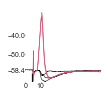

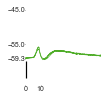

In [25]:
exptname = '20200607_005'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]

sweepdur = 0.03
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
theseT = trial_df[trial_df['ampshift']==-40].time.values - 0.005
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
R = R + Vm_offset[exptname]
ax.plot(xtime,R[:,-3:],color = 'black',lw = 0.5,label='low stimulus amp')
theseT = trial_df[trial_df['ampshift']==0].time.values - 0.005
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
R = R + Vm_offset[exptname]
ax.plot(xtime,R[:,-3:],color = colinds[5],lw = 0.5,label='baseline stimulus amp')
ax.set_xlim(0,50)
ax.set_ylim(-65,-25)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([np.round(np.median(R[0,:]),1),-50,-40])
ax.vlines(4.5,-65,-60)

figsave(figure_folder,'Fig1_dGRC_es')

# cmd response for this cell
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['B'])

hfig,ax = create_fig()
theseT = trial_df.time.values - 0.0005
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
R = R + Vm_offset[exptname]
ax.plot(xtime,R[:,-3:],color = [0.302, 0.675, 0.149],lw = 0.5)
ax.set_xlim(0,50)
ax.set_ylim(-67,-45)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([np.round(np.median(R[0,:]),1),-55,-45])
ax.vlines(0.5,-65,-60)

figsave(figure_folder,'Fig1_dGRC_cmd_inhib')

### example DGC cell 20200606_005

In [ ]:
# example cell
exptname = '20200606_005' 
stimamp = -20

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

# get stimulus amplitude for each trial
eventDur = 0.001
sweepdur = 0.05

bout = [expt.get_bout_win("R","Keyboard")[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

trialT = trial_df[trial_df['ampshift']==stimamp].time.values - 0.005
xtime,sweeps = expt.get_sweepsmat('lowgain',trialT,sweepdur)

hfig,ax = create_fig()

plt.plot(xtime,sweeps[:,0:4]-sweeps[0,0:4],color = 'lightgray',lw = 0.5)
plt.plot(xtime,sweeps[:,5:7]-sweeps[0,5:7],color = 'gray',lw = 0.5)
plt.plot(xtime,sweeps[:,4]-sweeps[0,4],color = 'black',lw = 0.5)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_ylim(-5,35)
ax.set_xticks([0,10])
ax.set_yticks([10,20])
ax.vlines(4.5,-65,-60)

figsave(figure_folder,'Fig1_dGRC_es_inhib')

### example SGC cell 20170502_002; ES no spikes

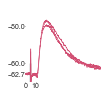

In [18]:
exptname = '20170502_002'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')

bout = [expt.get_bout_win('U','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
u_df = expt.filter_marker_df_code(bout_df,['E'])
u_t = u_df.time.values - 0.0003 - 0.005

hfig,ax = create_fig()
xtime, R = expt.get_sweepsmat('lowgain',u_t,sweepdur = 0.05)
R = R + Vm_offset[exptname]
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
ax.plot(xtime,R[:,-4:-2],color = colinds[5],lw = 0.5);
ax.plot(xtime,R[:,-1],color = colinds[5],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-65,-45)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([np.median(R[0,:]),-60,-50])
ax.vlines(4.5,-65,-60)

figsave(figure_folder,'Fig1_sGRC_es_50ms')

### example SGC cell 20200524_002; ES spikes

/Users/kperks/mnt/engram/spikedata/data_raw/20200524/20200524_002.smr


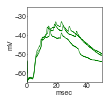

In [129]:
exptname = '20200524_002'

expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')

bout = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('N','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
base_df = expt.filter_marker_df_code(bout_df,['U'])

hfig,ax = create_fig()
xtime, R = expt.get_sweepsmat('lowgain',base_df.time.values,sweepdur = 0.05)
R = R + Vm_offset[exptname]
ax.plot(xtime,R[:,-3:],color = 'green',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-65,-25)
ax.set_xlabel('msec',labelpad = 0)
ax.set_ylabel('mV',labelpad = 0)

figsave(figure_folder,'Fig1_sGRC_es_spikes')

### example SGC cell 20180108_004; CD

/Users/kperks/mnt/engram/spikedata/data_raw/20180108/20180108_004.smr


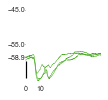

In [26]:
exptname = '20180108_004'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')

bout = [expt.get_bout_win('U','Keyboard')[0],expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
theseT = b_df.time.values - 0.0005

hfig,ax = create_fig()
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
R = R + Vm_offset[exptname]
ax.plot(xtime,R[:,-3:],color = [0.302, 0.675, 0.149],lw = 0.5)
ax.set_xlim(0,50)
ax.set_ylim(-67,-45)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([np.round(np.median(R[0,:]),1),-55,-45])
ax.vlines(0.5,-65,-60)

figsave(figure_folder,'Fig1_sGRC_cmd')

### example SGC cell 20200524_002; CD bias Vm

-44.73877
-89.06555


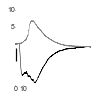

In [72]:
exptname = '20200524_002'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

sweepdur = 0.1
marker_df = expt.get_marker_table() 

hfig,ax = create_fig()
# ax.set_ylabel('mV')
# ax.set_xlabel('msec')

##cmd
bout = [expt.get_bout_win('B','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values - 0.0005,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'black',lw = 0.5);
print(np.median(sweeps,1)[0])

bout = [expt.get_bout_win('B','Keyboard')[2]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values - 0.0005,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'gray',lw = 0.5);
print(np.median(sweeps,1)[0])

ax.set_xlim(0,100)
ax.set_ylim(-12,-10)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(0.5,-5,-1)
# plt.legend(bbox_to_anchor=[1,1])



figsave(figure_folder,'Fig1_sGRC_cmd_hyperpol')

### example DGC cell 20191218_009; CD

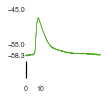

In [150]:
exptname = '20191218_009'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')

bout = [expt.get_bout_win('U','Keyboard')[0],expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
theseT = b_df.time.values - 0.0005

hfig,ax = create_fig()
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
R = R + Vm_offset[exptname]
ax.plot(xtime,R[:,-3:],color = [0.302, 0.675, 0.149],lw = 0.5)
ax.set_xlim(0,50)
ax.set_ylim(-67,-45)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([np.round(np.median(R[0,-3:]),1),-55,-45])
ax.vlines(0.5,-65,-60)

figsave(figure_folder,'Fig1_dGRC_cmd')

## uncoupled population average

### load uncoupled response data pickle

In [6]:
# created in 'GRC_properties_Meta_ipynb'
pickle_in = open(meta_data_folder / 'cell_data_uncoupled.pickle',"rb")
cell_data = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open(meta_data_folder / 'time_data_uncoupled.pickle',"rb")
time_data = pickle.load(pickle_in)
pickle_in.close()

### use metadata defined in sec5.1 to create dataframe

In [7]:
path = Path.cwd().resolve().parents[0] / 'data_processed' / 'df_GRC_properties'
files = [e for e in path.iterdir() if e.is_file() and e.suffix=='.csv']
keys = [f.name[0:-4] for f in sorted(files)]
meta_df = pd.DataFrame(columns = None)
for f in files:
    thisdf = pd.read_csv(f)
    meta_df = meta_df.append(thisdf,ignore_index = True)

meta_df['cell_type'] = meta_df['exptname'].map(cell_type)

### enable interactive plotting and create plot

In [195]:
%matplotlib qt

In [196]:
hfig = plt.figure(figsize = (5,8))
ax = hfig.add_axes([0.2,0.2,0.7,0.7])

### interactive select SGC ES response onsets; save as numpy

In [199]:
# which_cells = cell_meta_df[cell_meta_df['type']=='s'].index
which_cells = meta_df[meta_df['cell_type']=='s'].exptname.values

sweeps = []
sweepdur = 0.075
newdt = 1/10000
newsamp = int(sweepdur/newdt)
for cell in which_cells:
    sweep = signal.resample(cell_data[cell],newsamp)
    sweeps.append(sweep-sweep[0])
sweeps.append(np.zeros(newsamp))
sweeps = np.asarray(sweeps).T
xtime = np.linspace(0,75,newsamp)

onset = []
for sweep in sweeps.T:
    ax.cla()
    
    ax.plot(xtime,sweep,color='black')
    ax.set_xlim(6,20)
    
    x = np.asarray(hfig.ginput())
    onset.append(x[0][0])
#     print(x[0][0])

ax.cla()
sweeps_clip = []
offsetT = -2
x_clip = np.linspace(offsetT,50,int(50/1000/newdt)-int(offsetT/1000/newdt))
for o,sweep in zip(onset[1:],sweeps[:,0:-1].T):
    onsetind = int(o/1000/newdt)
    startind = onsetind + int((offsetT)/1000/newdt)
    stopind = onsetind + int((50)/1000/newdt)
    sweeps_clip.append(sweep[startind:stopind])
    ax.plot(x_clip,sweep[startind:stopind])
sweeps_clip = np.asarray(sweeps_clip).T
# ax.set_xlim()

np.save(meta_data_folder / 'uncoupled_response_pop_sgrc_onset.npy',onset,allow_pickle=False)
np.save(meta_data_folder / 'uncoupled_response_pop_sgrc_sweeps.npy',sweeps,allow_pickle=False)
np.save(meta_data_folder / 'uncoupled_response_pop_sgrc_sweeps_clip.npy',sweeps_clip,allow_pickle=False)

### interactive select DGC ES response onsets; save as numpy

In [198]:
# which_cells = cell_meta_df[cell_meta_df['type']=='s'].index
which_cells = meta_df[meta_df['cell_type']=='s'].exptname.values

sweeps = []
sweepdur = 0.075
newdt = 1/10000
newsamp = int(sweepdur/newdt)
for cell in which_cells:
    sweep = signal.resample(cell_data[cell],newsamp)
    sweeps.append(sweep-sweep[0])
sweeps.append(np.zeros(newsamp))
sweeps = np.asarray(sweeps).T
xtime = np.linspace(0,75,newsamp)

onset = []
for sweep in sweeps.T:
    ax.cla()
    
    ax.plot(xtime,sweep,color='black')
    ax.set_xlim(6,20)
    
    x = np.asarray(hfig.ginput())
    onset.append(x[0][0])
#     print(x[0][0])

ax.cla()
sweeps_clip = []
offsetT = -2
x_clip = np.linspace(offsetT,50,int(50/1000/newdt)-int(offsetT/1000/newdt))
for o,sweep in zip(onset[1:],sweeps[:,0:-1].T):
    onsetind = int(o/1000/newdt)
    startind = onsetind + int((offsetT)/1000/newdt)
    stopind = onsetind + int((50)/1000/newdt)
    sweeps_clip.append(sweep[startind:stopind])
    ax.plot(x_clip,sweep[startind:stopind])
sweeps_clip = np.asarray(sweeps_clip).T
# ax.set_xlim()

np.save(meta_data_folder / 'uncoupled_response_pop_dgrc_onset.npy',onset,allow_pickle=False)
np.save(meta_data_folder / 'uncoupled_response_pop_dgrc_sweeps.npy',sweeps,allow_pickle=False)
np.save(meta_data_folder / 'uncoupled_response_pop_dgrc_sweeps_clip.npy',sweeps_clip,allow_pickle=False)

### close figure and return to inline plotting

In [ ]:
plt.close(hfig)

%matplotlib inline

### load GC npy arrays and plot mean/sem

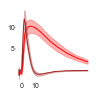

In [108]:
dgrc_sweeps_clip = np.load(meta_data_folder / 'uncoupled_response_pop_dgrc_sweeps_clip.npy')
sgrc_sweeps_clip = np.load(meta_data_folder / 'uncoupled_response_pop_sgrc_sweeps_clip.npy')
newdt = 1/10000
offsetT = -2
x_clip = np.linspace(offsetT,50,int(50/1000/newdt)-int(offsetT/1000/newdt))

hfig,ax = create_fig()

ax.plot(x_clip,np.mean(sgrc_sweeps_clip,1),color = 'red',lw = 1)
ax.fill_between(x_clip,
                np.mean(sgrc_sweeps_clip,1)-stats.sem(sgrc_sweeps_clip,1),
                np.mean(sgrc_sweeps_clip,1)+stats.sem(sgrc_sweeps_clip,1),
               color='red',alpha=0.3)

ax.plot(x_clip,np.mean(dgrc_sweeps_clip,1),color = 'brown',lw = 1)
ax.fill_between(x_clip,
                np.mean(dgrc_sweeps_clip,1)-stats.sem(dgrc_sweeps_clip,1),
                np.mean(dgrc_sweeps_clip,1)+stats.sem(dgrc_sweeps_clip,1),
               color='brown',alpha=0.3)

ax.vlines(0,1,4,color = 'black')
ax.set_xticks([0,10])
ax.set_yticks([5,10])
figsave(figure_folder,'Fig1_GRC_ES_popmean')

### load GC npy arrays and quantify response width at half height

In [55]:
dgrc_sweeps_clip = np.load(meta_data_folder / 'uncoupled_response_pop_dgrc_sweeps_clip.npy')
sgrc_sweeps_clip = np.load(meta_data_folder / 'uncoupled_response_pop_sgrc_sweeps_clip.npy')
newdt = 1/10000
offsetT = -2
x_clip = np.linspace(offsetT,50,int(50/1000/newdt)-int(offsetT/1000/newdt))


DGC_hwhh = []
for sweep in dgrc_sweeps_clip.T:
    peakmv = sweep[np.argmax(sweep)]
    halfon = np.min(x_clip[sweep>peakmv/2])
    halfoff = np.max(x_clip[sweep>peakmv/2])
    DGC_hwhh.append(halfoff-halfon)
DGC_hwhh = array(DGC_hwhh)

SGC_hwhh = []
for sweep in sgrc_sweeps_clip.T:
    peakmv = sweep[np.argmax(sweep)]
    halfon = np.min(x_clip[sweep>peakmv/2])
    halfoff = np.max(x_clip[sweep>peakmv/2])
    SGC_hwhh.append(halfoff-halfon)
SGC_hwhh = array(SGC_hwhh)

print('half-width at half height')
print('')
print('DGC')
print('mean = ' + str(np.round(np.mean(DGC_hwhh),1)) + 'ms; sem = ' 
     + str(np.round(stats.sem(DGC_hwhh),1)) + 'ms; n = ' + str(len(DGC_hwhh)))
print('')
print('SGC')
print('mean = ' + str(np.round(np.mean(SGC_hwhh),1)) + 'ms; sem = ' 
     + str(np.round(stats.sem(SGC_hwhh),1)) + 'ms; n = ' + str(len(SGC_hwhh)))

half-width at half height

DGC
mean = 3.6ms; sem = 0.3ms; n = 24

SGC
mean = 24.8ms; sem = 2.7ms; n = 18


## load DF_Istep.csv to quantify I-step Rin for text

In [50]:
meta_df = pd.read_csv('DF_Istep.csv')
Rin = []
for name in np.unique(meta_df['exptname']):
    this_df = meta_df[meta_df['exptname']==name]
    this_df = this_df[this_df['current_inj']<25]
#     print(np.round(np.median(this_df['onset_peak']/this_df['current_inj']),1),
#          np.round(np.median(this_df['offset_peak']/this_df['current_inj']),1))
    Rin.append(np.round(np.median(this_df['offset_peak']/this_df['current_inj']),1))

Rin_df = pd.DataFrame({
    'exptname' : np.unique(meta_df['exptname']),
    'Rin' : Rin
})

In [51]:
Rin_df['Rin'].describe()

count    25.000000
mean      0.824000
std       0.511762
min       0.300000
25%       0.400000
50%       0.600000
75%       1.300000
max       2.100000
Name: Rin, dtype: float64

In [52]:
stats.sem(Rin_df['Rin'])

0.1023523326553919

## prevent edge effects when resample by appending reversed signal
https://medium.com/analytics-vidhya/edge-effects-when-resampling-a-signal-on-matlab-how-to-solve-it-cc6458ab1306

## CD population average

### load SGC pickle data and create/save nmpy array

In [7]:
# created in 'GRC_properties_Meta_ipynb'
pickle_in = open(meta_data_folder / 'cell_data_cmd_superficial.pickle',"rb")
cell_data = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open(meta_data_folder / 'time_data_cmd_superficial.pickle',"rb")
time_data = pickle.load(pickle_in)
pickle_in.close()

In [8]:
sweeps = []
sweepdur = 0.075
newdt = 1/10000
newsamp = int(sweepdur/newdt)
for exptname,data in cell_data.items():
    sweep = data-data[0]
    sweep = np.concatenate([sweep[::-1],sweep,sweep[::-1]])
    sweep = signal.resample(sweep,3*newsamp)
    sweeps.append(sweep[newsamp:2*newsamp])
# sweeps.append(np.zeros(newsamp))
sweeps = np.asarray(sweeps).T
xtime = np.linspace(0,75,newsamp)

np.save(meta_data_folder / 'cmd_response_pop_sgrc_sweeps.npy',sweeps,allow_pickle=False)

### load DGC pickle data and create/save nmpy array

In [9]:
# created in 'GRC_properties_Meta_ipynb'
pickle_in = open(meta_data_folder / 'cell_data_cmd_deep.pickle',"rb")
cell_data = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open(meta_data_folder / 'time_data_cmd_deep.pickle',"rb")
time_data = pickle.load(pickle_in)
pickle_in.close()

In [10]:
sweeps = []
sweepdur = 0.075
newdt = 1/10000
newsamp = int(sweepdur/newdt)
for exptname,data in cell_data.items():
    sweep = data-data[0]
    sweep = np.concatenate([sweep[::-1],sweep,sweep[::-1]])
    sweep = signal.resample(sweep,3*newsamp)
    sweeps.append(sweep[newsamp:2*newsamp])
# sweeps.append(np.zeros(newsamp))
sweeps = np.asarray(sweeps).T
xtime = np.linspace(0,75,newsamp)

np.save(meta_data_folder / 'cmd_response_pop_dgrc_sweeps.npy',sweeps,allow_pickle=False)

### load GC numpy arrays and plot pop mean/sem

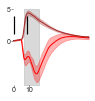

In [27]:
dgrc_sweeps_cmd = np.load(meta_data_folder / 'cmd_response_pop_dgrc_sweeps.npy')
sgrc_sweeps_cmd = np.load(meta_data_folder / 'cmd_response_pop_sgrc_sweeps.npy')
newdt = 1/10000
sweepclip = 0.05
dgrc_sweeps_cmd = dgrc_sweeps_cmd[0:int(sweepclip/newdt),:]
sgrc_sweeps_cmd = sgrc_sweeps_cmd[0:int(sweepclip/newdt),:]

xtime = np.linspace(0,sweepclip*1000,int(sweepclip/newdt))-0.5

hfig,ax = create_fig()
ax.fill_between([6.5,16.5],[5,5],[-7,-7],color = 'black', alpha = 0.15)
ax.plot(xtime,np.mean(sgrc_sweeps_cmd,1),color = 'red',lw = 1)
ax.fill_between(xtime,
                np.mean(sgrc_sweeps_cmd,1)-stats.sem(sgrc_sweeps_cmd,1),
                np.mean(sgrc_sweeps_cmd,1)+stats.sem(sgrc_sweeps_cmd,1),
               color='red',alpha=0.3)

ax.plot(xtime,np.mean(dgrc_sweeps_cmd,1),color = 'brown',lw = 1)
ax.fill_between(xtime,
                np.mean(dgrc_sweeps_cmd,1)-stats.sem(dgrc_sweeps_cmd,1),
                np.mean(dgrc_sweeps_cmd,1)+stats.sem(dgrc_sweeps_cmd,1),
               color='brown',alpha=0.3)

ax.vlines(0,1,4,color = 'black')
ax.vlines(7.5,1,4,color = 'black')
ax.set_xticks([0,10])
ax.set_yticks([0,5])
plt.xlim(-0.5,49.5)
plt.ylim(-7,5)
figsave(figure_folder,'Fig1_GRC_CMD_popmean')

# FIGURE 2

## import afferent spike data; only use well-fit data

20200129(blue) has a total of 11 afferents recorded
20200204(orange) has a total of 11 afferents recorded
20200531(brown) has a total of 27 afferents recorded
20200621(green) has a total of 15 afferents recorded
number afferents excluded because first fsl threshold too high or could not be fit: 3
number afferents included (spike thresh at least 0%): 61
        exptname    animal   stretch       tau    offset    max_fsl  \
1   20200129_003  20200129  5.002921 -0.017816  1.000000   9.532944   
4   20200129_006  20200129  5.715809 -0.022154  1.000000   9.858215   
7   20200129_009  20200129  5.451725 -0.015384  1.000000   9.357798   
10  20200129_012  20200129  6.623366 -0.019459  1.000000  12.010008   
1   20200531_001  20200531  6.964934 -0.020705  1.000000  11.347565   
7   20200531_007  20200531  3.842939 -0.038101  2.673761  11.087392   

           sse   df  
1   103.435863   94  
4    48.310496  108  
7    43.739012   40  
10   91.976468   85  
1    56.609527  105  
7   109.099794 

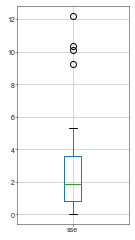

In [7]:
exptdate = 'all'
# meta_df.to_csv('DF_AfferentPopulation_' + exptdate + '.csv')
meta_df = pd.read_csv('DF_AfferentPopulation_' + exptdate + '.csv')

meta_params_df,expt_excluded = exclude_HighThreshAff(meta_df)

well_fit,un_fit = assess_fits(meta_params_df)

# meta_params_df = meta_params_df.dropna()
data_df = well_fit
dataset = list(zip(
    data_df['stretch'],
    data_df['tau'],
    data_df['offset'],
    data_df['max_fsl']
    ))
dataset = np.asarray(dataset)
# dataset = dataset[:,0:3]

rv = gaussian_kde(dataset[:,0:3].T)

max_fsl_global = np.max(meta_params_df['max_fsl'])

# plot_corr_matrix_multigauss(rv)

## example afferent latency tuning plot; store latency shift as vector for GC plot

WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


0
18
17
17
17
17
17
17
17
17
18


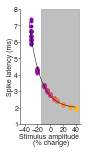

In [11]:
name = well_fit['exptname'].values[2]

expt_df = meta_df[meta_df['exptname'] == name]

x = np.arange(-40,40,1)#unique(expt_df.ampshift)
these_params = meta_params_df[meta_params_df['exptname']==name]
y = exp_fit(x,these_params['stretch'].values,these_params['tau'].values,these_params['offset'].values)
y[y>these_params['max_fsl'].values] = np.NaN  

colinds = plt.cm.plasma(np.linspace(0.2,0.85,len(np.unique(expt_df.ampshift))))

# hfig,ax = create_fig_tuning()
figsize=[1.2,2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.2,0.15,0.7,0.8])
ax.fill_betweenx([1,8],-15,45,color='gray',alpha=0.5)
ex_latshift = []
for i,a in enumerate(np.unique(expt_df.ampshift)):
    sub_df = expt_df[expt_df['ampshift']==a]
    x_data = sub_df.dropna(0).ampshift.values
    y_data =  sub_df.dropna(0).fsl.values
    print(len(y_data))
    ax.scatter(x_data,y_data,color=colinds[i],s=10)
    ex_latshift.append(np.mean(y_data))
ex_latshift = array(ex_latshift).T
    
ax.plot(x,y,color='black',lw = 0.5)
ax.set_xlim(-47,47)
ax.set_ylim(1,8)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_ylabel('Spike latency (ms)')
xticks([-40,-20,0,20,40])
sns.despine(hfig)

# figsave(figure_folder,'Fig2_ExampleAfferentTuning')

### for text: calculate afferent shift in latency across population; plot

In [13]:
x = array([-40,-30,-20,-10,-5,0,5,10,20,30,40])
restrict_inds = x>-20

y_fit = []
for i,animal in enumerate(np.unique(data_df['animal'])):
    animal_df = data_df[data_df['animal'] == animal]
    for name in np.unique(animal_df['exptname']):
        expt_df = animal_df[animal_df['exptname'] == name]
        y = exp_fit(x,expt_df['stretch'].values,expt_df['tau'].values,expt_df['offset'].values)
        y[y>11] = np.NaN
        y_fit.append(y)
y_fit = np.asarray(y_fit).T


dt_aff = []
for r in y_fit.T:
    dt_aff.append(r[restrict_inds][-1] - r[restrict_inds][0])
dt_aff = np.asarray(dt_aff).T
                

print('afferent tuning: mean ms change ' + str(np.round(np.nanmean(dt_aff),1)) + ' sem ' 
      + str(np.round(stats.sem(dt_aff,nan_policy='omit'),1)))

ax.plot(x[restrict_inds],np.nanmean(y_fit,1)[restrict_inds],color = 'green');
ax.fill_between(x[restrict_inds],
                np.nanmean(y_fit,1)[restrict_inds]-stats.sem(y_fit,1,nan_policy='omit')[restrict_inds],
                np.nanmean(y_fit,1)[restrict_inds]+stats.sem(y_fit,1,nan_policy='omit')[restrict_inds],
               color='green',alpha=0.3)


afferent tuning: mean ms change -2.0 sem 0.2


### compare example afferent tuning to population tuning

In [22]:
ex_latshift_pop = []
for r in y_fit:
    ex_latshift_pop.append(np.nanmean(r))
ex_latshift_pop = array(ex_latshift_pop)

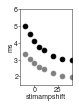

In [29]:
hfig,ax = create_fig_tuning()
# plt.figure(figsize=(2,3))
plt.scatter(x,ex_latshift,color = 'gray')
plt.scatter(x,ex_latshift_pop,color = 'black')
plt.xlim(-15,40)
plt.ylim(1.5,6)
plt.ylabel('ms')
plt.xlabel('stimampshift')
figsave(figure_folder,'Fig2_ExampleVsPop_AfferentTuning')

## example DGC amplitude tuning; plot agains example afferent latency instead of stimamp

/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_005.smr


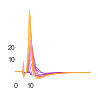

In [6]:
exptname = '20200607_005'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]

sweepdur = 0.05
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(trialmat)[1]))

for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([10,20])
ax.vlines(5,0,5)


# figsave(figure_folder,'Fig2_ExampleDGRCwavs')

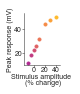

In [12]:
dt = expt.get_dt('lowgain')

amp = []
searchinds = xtime>6
for sweep in trialmat.T:
#     r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
#     amp.append(r_u[1])
    maxR = sweep[searchinds][np.argmax(sweep[searchinds])]
    amp.append(maxR)
amp = np.asarray(amp)

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

# figsize=[1.2,1.5]
# hfig = plt.figure(figsize = [1,1.25])
# ax = hfig.add_axes([0.3,0.2,0.6,0.7])
# figsize = [0.75,1]
# hfig,ax = create_fig_tuning()
figsize=[1,1.2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.3,0.5,0.6])
# ax.plot(stim_ampshift[restrict_inds],amp[restrict_inds],color = 'black')
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
i = 3
for s,r in zip(stim_ampshift[restrict_inds],amp[restrict_inds]):
    ax.scatter(s,r,color = colinds[i], s=10)
    i+=1
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_ylabel('Peak response (mV)');
sns.despine(hfig)

figsave(figure_folder,'Fig2_ExampleDGRCscatter')

## example SGC amplitude tuning; plot agains example afferent latency instead of stimamp


/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_000.smr


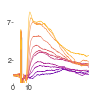

In [13]:
exptname = '20200607_000'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[1],
          expt.get_bout_win('R','Keyboard')[2]]

sweepdur = 0.05
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(trialmat)[1]))

for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-1,9)
# ax.set_xlabel('msec')
# ax.set_ylabel('mV')
ax.set_xticks([0,10])
ax.set_yticks([2,7])
ax.vlines(5,0,5)

figsave(figure_folder,'Fig2_ExampleSGRCwavs')

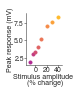

In [14]:
dt = expt.get_dt('lowgain')

amp = []
searchinds = xtime>6
for sweep in trialmat.T:
#     r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
#     amp.append(r_u[1])
    maxR = sweep[searchinds][np.argmax(sweep[searchinds])]
    amp.append(maxR)
amp = np.asarray(amp)

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

figsize=[1,1.2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.3,0.5,0.6])
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
i = 3
for s,r in zip(stim_ampshift[restrict_inds],amp[restrict_inds]):
    ax.scatter(s,r,color = colinds[i], s=10)
    i+=1
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_ylabel('Peak response (mV)');
sns.despine(hfig)

figsave(figure_folder,'Fig2_ExampleSGRCscatter')

## population amplitude tuning curves

### DGC

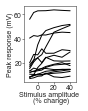

In [33]:
#deep grc
meta_df = pd.read_csv('DF_update_dGRCPopulation_UncoupledAmpShift.csv')
R_ampshift = []
R_ampshift_norm = []
for a in np.unique(meta_df['exptname']):
    subdf = meta_df[meta_df['exptname']==a].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift.append(r)
#     r = (r-np.min(r))
    r = r/np.max(r)
    R_ampshift_norm.append(r)
R_ampshift_dgc = np.asarray(R_ampshift)
R_ampshift_norm_dgrc = np.asarray(R_ampshift_norm)
stim_ampshift = np.unique(meta_df.ampshift)

R_ampshift_dgrc = R_ampshift

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
for name,expt_result in zip(np.unique(meta_df['exptname']),R_ampshift):
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',color='black',lw=1)#,marker='o',markersize=6)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);

# figsave(figure_folder,'Fig2_dgrcTuning_pop')

### SGC 

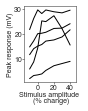

In [34]:
#superficial grc
meta_df = pd.read_csv('DF_update_sGRCPopulation_UncoupledAmpShift.csv')
R_ampshift = []
R_ampshift_norm = []
for a in np.unique(meta_df['exptname']):
    subdf = meta_df[meta_df['exptname']==a].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift.append(r)
#     r = (r-np.min(r))
    r = r/np.max(r)
    R_ampshift_norm.append(r)
R_ampshift_sgc = np.asarray(R_ampshift)
R_ampshift_norm_sgrc = np.asarray(R_ampshift_norm)
stim_ampshift = np.unique(meta_df.ampshift)

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
for name,expt_result in zip(np.unique(meta_df['exptname']),R_ampshift):
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
# figsave(figure_folder,'Fig2_sgrcTuning_pop')

### MF 

In [35]:
#medium fusiform
meta_df = pd.read_csv('DF_MFPopulation_UncoupledAmpShift.csv')

R_ampshift = []
R_ampshift_norm = []
# R_fsl = []
for a in np.unique(meta_df['exptname']):
#     subdf = meta_df[(meta_df['exptname']==a)&(meta_df['nspk']==0)].groupby('ampshift')
    subdf = meta_df[(meta_df['exptname']==a)].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift.append(r)
#     r = (r-np.min(r))
    r = r/np.max(r)
    R_ampshift_norm.append(r)
#     R_fsl.append(subdf.fsl.mean().values)
R_ampshift_mf = np.asarray(R_ampshift)
R_ampshift_norm_mf = np.asarray(R_ampshift_norm)
# R_fsl = np.asarray(R_fsl)
stim_ampshift = np.unique(meta_df.ampshift)

### OutputE 

In [ ]:
meta_df = pd.read_csv('DF_OutputEPopulation_UncoupledAmpShift.csv')

R_ampshift = []
R_ampshift_norm = []
# R_fsl = []
for a in np.unique(meta_df['exptname']):
    subdf = meta_df[(meta_df['exptname']==a)&(meta_df['nspk']==0)].groupby('ampshift')
    r = subdf.spkamp.mean().values
    R_ampshift.append(r)
#     r = (r-np.min(r))
    r = r/np.max(r)
    R_ampshift_norm.append(r)
#     R_fsl.append(subdf.fsl.mean().values)
R_ampshift = np.asarray(R_ampshift)
R_ampshift_norm_out = np.asarray(R_ampshift_norm)
# R_fsl = np.asarray(R_fsl)
stim_ampshift = np.unique(meta_df.ampshift)

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
# plt.errorbar(stim_ampshift,np.mean(R_ampshift_norm,0),yerr=stats.sem(R_ampshift_norm,0),linestyle="None",color = 'black')
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_out,0)[restrict_inds],color = 'black',s = 6**2)
# ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_dgrc,0)[restrict_inds],color = 'brown',s = 6**2)
# ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc,0)[restrict_inds],color = 'red',s=6**2)

ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
ax.set_ylim(0.35,1.05)
xticks([0,20,40]);
# ax.set_xscale('log')
figsave(figure_folder,'Fig2_output_Tuning_MeanNorm')


hfig,ax = create_fig_tuning()
for name,expt_result in zip(np.unique(meta_df['exptname']),R_ampshift):
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',color='black',lw=1)#,marker='o',markersize=6)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);

### GC population plot/quantify summary mean/sem scatter amplitude tuning curves

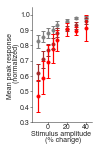

In [46]:

restrict_inds = stim_ampshift>-20
# hfig,ax = create_fig_tuning()
figsize=[1.2,2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.15,0.7,0.8])
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_mf,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_norm_mf,0)[restrict_inds],
             linestyle="None",color = 'gray', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_mf,0)[restrict_inds],color = 'gray',s = 10)
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_dgrc,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_norm_dgrc,0)[restrict_inds],
             linestyle="None",color = 'brown', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_dgrc,0)[restrict_inds],color = 'brown',s = 10)
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_sgrc,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_norm_sgrc,0)[restrict_inds],
             linestyle="None",color = 'red', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc,0)[restrict_inds],color = 'red',s=10)

ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
plt.ylim(0.3,1.05)
sns.despine(hfig)

# figsave(figure_folder,'Fig2_grc_mf_Tuning_MeanNorm')

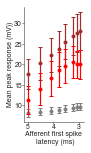

In [45]:
restrict_inds = stim_ampshift>-20
# hfig,ax = create_fig_tuning()
figsize=[1.2,2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.15,0.7,0.8])
plt.errorbar(ex_latshift_pop[restrict_inds],
             np.mean(R_ampshift_mf,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_mf,0)[restrict_inds],
             linestyle="None",color = 'gray', capsize=2)
ax.scatter(ex_latshift_pop[restrict_inds],np.mean(R_ampshift_mf,0)[restrict_inds],color = 'gray',s = 10)
plt.errorbar(ex_latshift_pop[restrict_inds],
             np.mean(R_ampshift_dgc,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_dgc,0)[restrict_inds],
             linestyle="None",color = 'brown', capsize=2)
ax.scatter(ex_latshift_pop[restrict_inds],np.mean(R_ampshift_dgc,0)[restrict_inds],color = 'brown',s = 10)
plt.errorbar(ex_latshift_pop[restrict_inds],
             np.mean(R_ampshift_sgc,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_sgc,0)[restrict_inds],
             linestyle="None",color = 'red', capsize=2)
ax.scatter(ex_latshift_pop[restrict_inds],np.mean(R_ampshift_sgc,0)[restrict_inds],color = 'red',s=10)

ax.set_ylabel('Mean peak response (mV))',linespacing=0.75)
# ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlabel('Afferent first spike \n latency (ms)')
# ax.set_xlim(-17,47)
# xticks([0,20,40]);
# plt.ylim(0.3,1.05)
ax.invert_xaxis()
sns.despine(hfig)

figsave(figure_folder,'Fig2_grc_mf_Tuning_Mean_vs_latshift')

In [55]:
dV_sgc = []
for r in R_ampshift_sgc:
    dV_sgc.append(r[-1]-r[3])
dV_sgc = array(dV_sgc)

dV_dgc = []
for r in R_ampshift_dgc:
    dV_dgc.append(r[-1]-r[3])
dV_dgc = array(dV_dgc)


print('afferent tuning across relevant stimulus range (ms):')
print('mean = ' + str(np.round(np.nanmean(dt_aff),1)) + 'ms' + 
      '; sem = ' + str(np.round(stats.sem(dt_aff,nan_policy='omit'),1)))
print('')
print('GC tuning across relevant stimulus range (mV):')
print('')
print('dgc:')
print('mean = ' + str(np.round(np.mean(dV_dgc),1)) + 'mV' +  
     '; sem = ' + str(np.round(stats.sem(dV_dgc),1)) + 'mV')
print('')
print('sgc:')
print('mean = ' + str(np.round(np.mean(dV_sgc),1)) + 'mV' + 
     '; sem = ' + str(np.round(stats.sem(dV_sgc),1)) + 'mV')



afferent tuning across relevant stimulus range (ms):
mean = -2.0ms; sem = 0.2

GC tuning across relevant stimulus range (mV):

dgc:
mean = 10.5mV; sem = 3.1mV

sgc:
mean = 8.7mV; sem = 0.6mV


# FIGURE 3


## load afferent data and filter for well_fit

20200129(blue) has a total of 11 afferents recorded
20200204(orange) has a total of 11 afferents recorded
20200531(brown) has a total of 27 afferents recorded
20200621(green) has a total of 15 afferents recorded
number afferents excluded because first fsl threshold too high or could not be fit: 3
number afferents included (spike thresh at least 0%): 61
        exptname    animal   stretch       tau    offset    max_fsl  \
1   20200129_003  20200129  5.002921 -0.017816  1.000000   9.532944   
4   20200129_006  20200129  5.715809 -0.022154  1.000000   9.858215   
7   20200129_009  20200129  5.451725 -0.015384  1.000000   9.357798   
10  20200129_012  20200129  6.623366 -0.019459  1.000000  12.010008   
1   20200531_001  20200531  6.964934 -0.020705  1.000000  11.347565   
7   20200531_007  20200531  3.842939 -0.038101  2.673761  11.087392   

           sse   df  
1   103.435863   94  
4    48.310496  108  
7    43.739012   40  
10   91.976468   85  
1    56.609527  105  
7   109.099794 

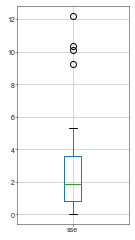

In [56]:
exptdate = 'all'
# meta_df.to_csv('DF_AfferentPopulation_' + exptdate + '.csv')
meta_df = pd.read_csv('DF_AfferentPopulation_' + exptdate + '.csv')

meta_params_df,expt_excluded = exclude_HighThreshAff(meta_df)

well_fit,un_fit = assess_fits(meta_params_df)

# meta_params_df = meta_params_df.dropna()
data_df = well_fit
dataset = list(zip(
    data_df['stretch'],
    data_df['tau'],
    data_df['offset'],
    data_df['max_fsl']
    ))
dataset = np.asarray(dataset)
# dataset = dataset[:,0:3]

rv = gaussian_kde(dataset[:,0:3].T)

max_fsl_global = np.max(meta_params_df['max_fsl'])

# plot_corr_matrix_multigauss(rv)
filtered_df = meta_df[meta_df.exptname.str.match('|'.join(well_fit.exptname.values))]

## plot afferent population from example animal  

### print number of afferents recorded

In [23]:
x = np.unique(meta_df.ampshift) #array([-40,-30,-20,-10,-5,0,5,10,20,30,40])
spk_thresh = 10

animal = 20200531
animal_df = well_fit[well_fit['animal'] == animal]
print(str(animal) + ' has a total of ' + 
      str(len(np.unique(animal_df['exptname']))) + ' afferents recorded')

20200531 has a total of 21 afferents recorded


### scatter percent online across stimamp

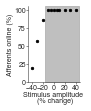

In [24]:
# for experiment in well fit (animal)
spk_trials = []
for cell in well_fit[well_fit['animal'] == animal].exptname:
    spk_trials.append(meta_df[meta_df['exptname']==cell].groupby('ampshift').fsl.count().values)
spk_trials = np.asarray(spk_trials).T

n_active = np.asarray([len(np.where(t>0)[0]) for t in spk_trials])
n_total = np.shape(spk_trials)[1]


hfig,ax = create_fig_tuning()
ax.fill_betweenx([0,105],-15,45,color='gray',alpha=0.5)

ax.scatter(np.unique(meta_df['ampshift']),100*(n_active/n_total),
           color='black',s=6)

ax.set_xlim(-47,47)
ax.set_ylim(0,105)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_ylabel('Afferents online (%)')
xticks([-40,-20,0,20,40]);
sns.despine(hfig)

figsave(figure_folder,'Fig3_AffOnlinePercent')

### plot all tuning curves and average scatter of fsl stdev for each amplitude

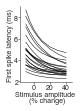

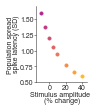

In [31]:

x = np.unique(meta_df['ampshift'])
x = x[x>-20]

animal_df = well_fit[well_fit['animal'] == animal]

spk_thresh = 12
y_fit = []
for name in np.unique(animal_df['exptname']):
    expt_df = animal_df[animal_df['exptname'] == name]
#     print(expt_df)
    y = exp_fit(x,expt_df['stretch'].values,expt_df['tau'].values,expt_df['offset'].values)
    y[y>spk_thresh] = np.NaN
    y_fit.append(y)
y_fit = np.asarray(y_fit).T

hfig,ax = create_fig_tuning()
ax.plot(x,y_fit,color = 'black',lw = 0.5)
ax.set_ylabel('First spike latency (ms)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig3_AffTuningHeterogeneityExampleAnimal')

hfig,ax = create_fig_tuning()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
i = 3
for s,r in zip(x,np.nanstd(y_fit,1)):
    ax.scatter(s,r,color = colinds[i], s=10)
    i+=1
# ax.scatter(x,np.nanstd(y_fit,1),color = 'black',s=10)
ax.set_ylabel(' Population spread \n spike latency (SD)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_ylim(0.5,1.7)
sns.despine(hfig)
figsave(figure_folder,'Fig3_PopLatencySTD')



## tuning curve parameter scatter across all animals

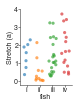

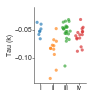

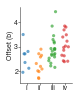

In [26]:
##########################
# split params for each animal by column in plots
##########################

hfig,ax = create_fig_tuning()
g = sns.stripplot(x = 'animal', y = 'stretch', data=well_fit,ax=ax,jitter=0.3,size=sqrt(10),alpha = 0.65)
g.set(xticklabels=['i','ii','iii','iv'])
ax.set_ylabel('Stretch (a)')
ax.set_xlabel('fish')
sns.despine()
figsave(figure_folder,'Fig3_ParamsStretch')


hfig,ax = create_fig_tuning()
g = sns.stripplot(x = 'animal', y = 'tau', data=well_fit,ax=ax,jitter=0.3,size=sqrt(10),alpha = 0.65)
g.set(xticklabels=['i','ii','iii','iv'])
ax.set_ylabel('Tau (k)')
ax.set_xlabel('')
sns.despine()
figsave(figure_folder,'Fig3_ParamsTau')


hfig,ax = create_fig_tuning()
g = sns.stripplot(x = 'animal', y = 'offset', data=well_fit,ax=ax,jitter=0.3,size=sqrt(10),alpha = 0.65)
g.set(xticklabels=['i','ii','iii','iv'])
ax.set_ylabel('Offset (b)')
ax.set_xlabel('')
sns.despine()
figsave(figure_folder,'Fig3_ParamsOffset')



## MODEL: DGC

###  initialize model specific for DGC

In [27]:
namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 6*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_inputs'] = 8
namespace_sim['e_lmi_delay'] = 2
namespace_sim['maxas'] = 3.5 
namespace_sim['minas'] = 0 
namespace_sim['midpt'] = 2 
namespace_sim['slp'] = 3

x = np.asarray([-10,-5,0,5,10,20,30,40])

### set inhibition to False (0); get example wavs and scatter data

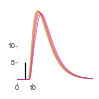

In [45]:
namespace_sim['w_e_lmi'] = 0
namespace_sim['N_runs'] = 1

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i+3],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Fig3_ExampleModel_deep_NoInhib')

# multiple runs to get amp readout estimate
namespace_sim['N_runs'] = 15

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
R_norm_deep_noinhib = np.asarray([r/np.max(r) for r in R_amp.T]).T

### set inhibition to True (1); get example wavs and scatter data

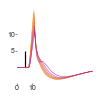

In [48]:
namespace_sim['w_e_lmi'] = 1

#sinlge run to get example wavs
namespace_sim['N_runs'] = 1

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Fig3_ExampleModel_deep_WithInhib')

# multiple runs to get amp readout
namespace_sim['N_runs'] = 15

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
R_norm_deep_inhib = np.asarray([r/np.max(r) for r in R_amp.T]).T

#### plot scatter of model (+/- inhib) against data

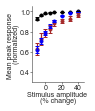

In [30]:
hfig,ax = create_fig_tuning()
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_dgrc,0)[restrict_inds],
             yerr=stats.sem(R_ampshift_norm_dgrc,0)[restrict_inds],
             linestyle="None",color = 'brown', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_dgrc,0)[restrict_inds],color = 'brown',s = 10)
plt.errorbar(x,np.mean(R_norm_deep_noinhib,1),yerr=stats.sem(R_norm_deep_noinhib,1),linestyle="None",color = 'black', capsize=2)
ax.scatter(x,np.mean(R_norm_deep_noinhib,1),color = 'black',s=10)
plt.errorbar(x,np.mean(R_norm_deep_inhib,1),yerr=stats.sem(R_norm_deep_inhib,1),linestyle="None",color = 'blue', capsize=2)
ax.scatter(x,np.mean(R_norm_deep_inhib,1),color = 'blue',s=10)
ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
plt.ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Fig3_deep_norm_inhibVSnot')

### in what way does model not capture response amplitude amplification? ...plot raw amplitudes (rather than normalized) and compare

In [19]:
x = np.asarray([-40,-30,-20,-10,-5,0,5,10,20,30,40])

namespace_sim['N_runs'] = 15
namespace_sim['w_e_lmi'] = 1

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig_tuning()
plt.errorbar(stim_ampshift,np.mean(R_ampshift_dgrc,0),yerr=stats.sem(R_ampshift_dgrc,0),linestyle="None",color = 'brown', capsize=2)
ax.scatter(stim_ampshift,np.mean(R_ampshift_dgrc,0),color = 'brown',s = 10)
plt.errorbar(x,np.mean(R_amp,1),yerr=stats.sem(R_amp,1),linestyle="None",color = 'blue', capsize=2)
ax.scatter(x,np.mean(R_amp,1),color = 'blue',s=10)
ax.set_ylabel('Mean peak response (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
# plt.ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Fig3_deep_absolute_modelVSdata')

### dependence of effect on cell model parameters

In [ ]:
x = np.asarray([-10,-5,0,5,10,20,30,40])

#### Cm

In [71]:
Cm = [2,4,6,8,10,12,14,16,18,20]
R_norm = []
for c in Cm:
    namespace_sim = reset_namespace_defaults()

    namespace_sim['Cm'] = c*pF
    namespace_sim['w_e'] = 0.1*nS
    namespace_sim['N_runs'] = 5
    namespace_sim['N_inputs'] = 8
    namespace_sim['w_e_lmi'] = 1
    namespace_sim['e_lmi_delay'] = 2

    net, namespace_sim = initialize_model(namespace_sim)
    net.store('intialized',filename=sim_filepath)

    x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
    R_norm.append(np.mean(np.asarray([r/np.max(r) for r in R_amp.T]).T,1))
R_norm = np.asarray(R_norm).T

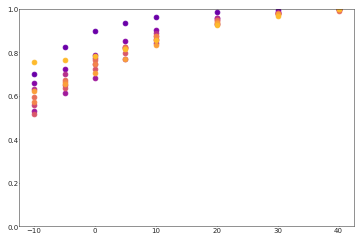

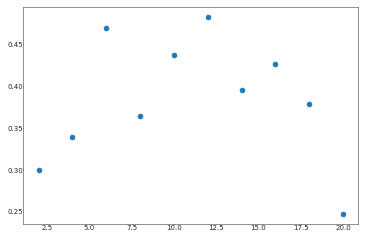

In [73]:
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_norm)[1]))

for i,r in enumerate(R_norm.T):
    plt.scatter(x,r,color = colinds[i])
plt.ylim(0,1)

plt.figure()
plt.scatter(Cm,array([r[-1]-r[0] for r in R_norm.T]))

#### tau rise

In [59]:
rise = [1,2,3,4,5,6,7,8,9,10]
R_norm = []
for r in rise:
    namespace_sim = reset_namespace_defaults()
    namespace_sim['taue_1'] = r*ms
    namespace_sim['Cm'] = 12*pF
    namespace_sim['w_e'] = 0.1*nS
    namespace_sim['N_runs'] = 5
    namespace_sim['N_inputs'] = 8
    namespace_sim['w_e_lmi'] = 1
    namespace_sim['e_lmi_delay'] = 2

    net, namespace_sim = initialize_model(namespace_sim)
    net.store('intialized',filename=sim_filepath)

    x = np.asarray([-10,-5,0,5,10,20,30,40])
    x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
    R_norm.append(np.mean(np.asarray([r/np.max(r) for r in R_amp.T]).T,1))
R_norm = np.asarray(R_norm).T

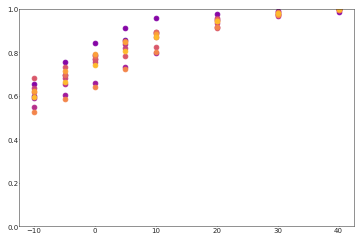

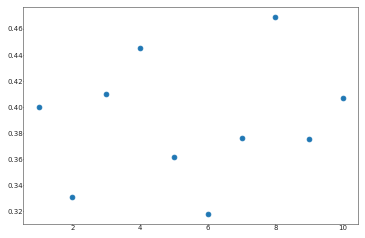

In [70]:
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_norm)[1]))

for i,r in enumerate(R_norm.T):
    plt.scatter(x,r,color = colinds[i])
plt.ylim(0,1)

plt.figure()
plt.scatter(rise,array([r[-1]-r[0] for r in R_norm.T]))
# plt.scatter(rise,[np.max(np.diff(r)) for r in R_norm.T])

## MODEL : SGC 

### model initialization; modify Cm and inhib dependence on Vm and tau_lmi

In [10]:
namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 12*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_inputs'] = 8
namespace_sim['e_lmi_delay'] = 2
namespace_sim['minas_'] = 1
namespace_sim['maxas_'] = 1.75
namespace_sim['midpt_'] = 1 #1
namespace_sim['slp_'] = 3
namespace_sim['tau_e_lmi'] = 10*ms

x = np.asarray([-10,-5,0,5,10,20,30,40])

### set inhibition to False(0); get example wavs and scatter data

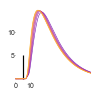

In [195]:
namespace_sim['w_e_lmi'] = 0
namespace_sim['N_runs'] = 1

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_wavs)[1]))

for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)


figsave(figure_folder,'Fig3_ExampleModel_sup_NoInhib')


# scatter data for multiple runs
namespace_sim['N_runs'] = 15

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
R_norm_sup_noinhib = np.asarray([r/np.max(r) for r in R_amp.T]).T

### set inhibition to True(1); get example waves and scatter data

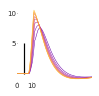

In [155]:
namespace_sim['N_runs'] = 1
namespace_sim['w_e_lmi'] = 1

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)
 

xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_wavs)[1]))

for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)


figsave(figure_folder,'Fig3_ExampleModel_sup_WithInhib_max1p75')

# multiple runs to get amp radout estimat
namespace_sim['N_runs'] = 1

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
R_norm_sup_inhib = np.asarray([r/np.max(r) for r in R_amp.T]).T

### plot scatter of model (+/- inhib) against data

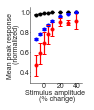

In [19]:
hfig,ax = create_fig_tuning()
plt.errorbar(stim_ampshift,np.mean(R_ampshift_norm_sgrc,0),yerr=stats.sem(R_ampshift_norm_sgrc,0),linestyle="None",color = 'red', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc,0)[restrict_inds],color = 'red',s = 10)
plt.errorbar(x,np.mean(R_norm_sup_noinhib,1),yerr=stats.sem(R_norm_sup_noinhib,1),linestyle="None",color = 'black', capsize=2)
ax.scatter(x,np.mean(R_norm_sup_noinhib,1),color = 'black',s=10)
plt.errorbar(x,np.mean(R_norm_sup_inhib,1),yerr=stats.sem(R_norm_sup_inhib,1),linestyle="None",color = 'blue', capsize=2)
ax.scatter(x,np.mean(R_norm_sup_inhib,1),color = 'blue',s=10)
ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Fig3_sup_norm_inhibVSnot_max1p75')

### dependence of effect on cell model parameters

#### tau lmi

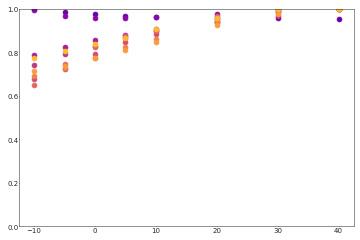

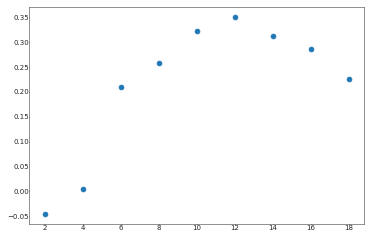

In [140]:
v_ = np.arange(2,20,2)
R_norm = []
for v in v_:
    namespace_sim['tau_e_lmi'] = v*ms

    net, namespace_sim = initialize_model(namespace_sim)
    net.store('intialized',filename=sim_filepath)

    x = np.asarray([-10,-5,0,5,10,20,30,40])
    x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
    R_norm.append(np.mean(np.asarray([r/np.max(r) for r in R_amp.T]).T,1))
R_norm = np.asarray(R_norm).T

colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_norm)[1]))
for i,r in enumerate(R_norm.T):
    plt.scatter(x,r,color = colinds[i])
plt.ylim(0,1)

plt.figure()
plt.scatter(v_,array([r[-1]-r[0] for r in R_norm.T]))

#### maximum asymptote of inhibition synapse weight

In [85]:
v_ = np.arange(1,4,0.5)
R_norm = []

namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 12*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_runs'] = 10
namespace_sim['N_inputs'] = 8
namespace_sim['w_e_lmi'] = 1
namespace_sim['e_lmi_delay'] = 2
namespace_sim['minas_'] = 1
for v in v_:
    namespace_sim['maxas_'] = v

    net, namespace_sim = initialize_model(namespace_sim)
    net.store('intialized',filename=sim_filepath)

    x = np.asarray([-10,-5,0,5,10,20,30,40])
    x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
    R_norm.append(np.mean(np.asarray([r/np.max(r) for r in R_amp.T]).T,1))
R_norm = np.asarray(R_norm).T

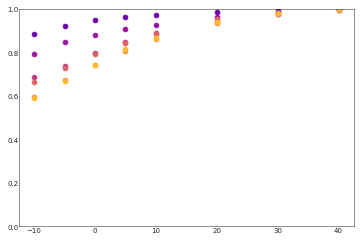

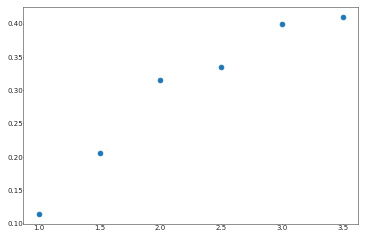

In [86]:
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_norm)[1]))

for i,r in enumerate(R_norm.T):
    plt.scatter(x,r,color = colinds[i])
plt.ylim(0,1)
plt.figure()
plt.scatter(v_,array([r[-1]-r[0] for r in R_norm.T]))

#### Cm

In [47]:
Cm = [2,4,6,8,10,12,14,16,18,20]
R_norm = []
for c in Cm:
    namespace_sim = reset_namespace_defaults()

    namespace_sim['Cm'] = c*pF
    namespace_sim['w_e'] = 0.1*nS
    namespace_sim['N_runs'] = 5
    namespace_sim['N_inputs'] = 8
    namespace_sim['w_e_lmi'] = 1
    namespace_sim['e_lmi_delay'] = 2

    net, namespace_sim = initialize_model(namespace_sim)
    net.store('intialized',filename=sim_filepath)

    x = np.asarray([-10,-5,0,5,10,20,30,40])
    x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
    R_norm.append(np.mean(np.asarray([r/np.max(r) for r in R_amp.T]).T,1))
R_norm = np.asarray(R_norm).T

(0.0, 1.0)

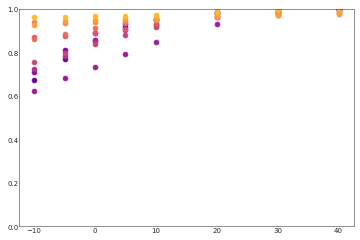

In [52]:
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_norm)[1]))

for i,r in enumerate(R_norm.T):
    plt.scatter(x,r,color = colinds[i])
plt.ylim(0,1)

#### tau rise

In [53]:
rise = [1,2,3,4,5,6,7,8,9,10]
R_norm = []
for r in rise:
    namespace_sim = reset_namespace_defaults()
    namespace_sim['taue_1'] = r*ms
    namespace_sim['Cm'] = 12*pF
    namespace_sim['w_e'] = 0.1*nS
    namespace_sim['N_runs'] = 5
    namespace_sim['N_inputs'] = 8
    namespace_sim['w_e_lmi'] = 1
    namespace_sim['e_lmi_delay'] = 2

    net, namespace_sim = initialize_model(namespace_sim)
    net.store('intialized',filename=sim_filepath)

    x = np.asarray([-10,-5,0,5,10,20,30,40])
    x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
    R_norm.append(np.mean(np.asarray([r/np.max(r) for r in R_amp.T]).T,1))
R_norm = np.asarray(R_norm).T

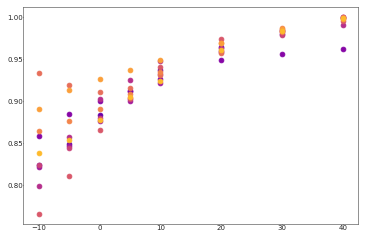

In [55]:
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_norm)[1]))

for i,r in enumerate(R_norm.T):
    plt.scatter(x,r,color = colinds[i])
# plt.ylim(0,1)

## multiple spikes 

### import csv data for each animal containing all afferent spikes

In [ ]:
# created using ipynb 'Afferent_MultiSpikeConcern'
meta_df = pd.DataFrame
meta_df.append(pd.read_csv('DF_Afferent_MultiSpikePop_20200129.csv'))
meta_df.append(pd.read_csv('DF_Afferent_MultiSpikePop_20200204.csv'))
meta_df.append(pd.read_csv('DF_Afferent_MultiSpikePop_20200531.csv'))
meta_df.append(pd.read_csv('DF_Afferent_MultiSpikePop_20200621.csv'))

### for each afferent and spike number, fit params

In [ ]:
params_df = pd.DataFrame(columns = ['a','k','b','cell','spk'])
for name in np.unique(meta_df['exptname']):
#     hfig,ax = create_fig_tuning()
    # name = np.unique(meta_df.exptname)[0]
    exptdf = meta_df[meta_df['exptname']==name]
    for spkt in ['s0t','s1t','s2t']:
        spkdf = exptdf[['ampshift',spkt]].dropna(0)
    
        if len(np.unique(spkdf['ampshift']))>=5: #if at least x stim that resopnds to, try to fit data
            x_data = spkdf['ampshift'].values
            y_data =  spkdf[spkt].values
            spk_thresh = np.max(y_data)
            params, params_covariance = optimize.curve_fit(exp_fit, x_data, y_data, 
                                                           p0=[1,-0.05, 3],
                                                           bounds = ([0,-1,1],[np.inf,0,10]),
                                                           maxfev=1000)
        if len(np.unique(spkdf['ampshift']))<5:
            params = [np.NaN,np.NaN,np.NaN]
            
        cell_df = {
            'a' : params[0],
            'k' : params[1],
            'b' : params[2],
            'cell' : name,
            'spk' : spkt[1]
        }
        params_df = params_df.append(cell_df,ignore_index=True)

### example afferents first and second spike scatters

In [ ]:
spk0_data = {}
spk1_data = {}
for name in np.unique(meta_df['exptname']):
    exptdf = meta_df[meta_df['exptname']==name]
    
    spkt = 's0t'
    spkdf = exptdf[['ampshift',spkt]]
    t_ = spkdf.groupby('ampshift')[spkt].mean().values
    spk0_data[name]=t_
    
    spkt = 's1t'
    spkdf = exptdf[['ampshift',spkt]]
    t_ = spkdf.groupby('ampshift')[spkt].mean().values
    spk1_data[name]=t_

In [ ]:
hfig,ax = create_fig_tuning()

name = '20200531_020'
ax.scatter(amps,spk0_data[name],color = 'orange',s=10)
ax.scatter(amps,spk1_data[name],color = 'purple',s=10)

name = '20200531_024'
ax.scatter(amps,spk0_data[name],color = 'orange',facecolors='none',s=10)
ax.scatter(amps,spk1_data[name],color = 'purple',facecolors='none',s=10)

plt.ylim(2,10)

ax.set_ylabel('Spike latency (ms)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
ax.set_ylim(2,12)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_TuningCurves_ExampleCells')

### tuning across afferents and within afferents

In [ ]:
min_n_spikes = 5

across = []
tuning0 = []
for i,x in enumerate(np.unique(meta_df['exptname'])):
    for j,y in enumerate(np.unique(meta_df['exptname'])):
        if j>i:
            if ((len(spk0_data[x][~isnan(spk0_data[x])])>min_n_spikes) & 
                (len(spk0_data[y][~isnan(spk0_data[y])])>min_n_spikes)):
                if ((len(spk1_data[x][~isnan(spk1_data[x])])>min_n_spikes) & 
                    (len(spk1_data[y][~isnan(spk1_data[y])])>min_n_spikes)):
                    tuning0.append(spk0_data[x])
                    
                    if spk0_data[x][-1]>spk0_data[y][-1]:
                        across.append(spk0_data[x]-spk0_data[y])
        #                 across.append(spk1_data[x]-spk1_data[y])
                    if spk0_data[y][-1]>spk0_data[x][-1]:
                        across.append(spk0_data[y]-spk0_data[x])
        #                 across.append(spk1_data[y]-spk1_data[x])
tuning0 = array(tuning0).T
across = array(across).T

within = []
tuning1 = []
for i,x in enumerate(np.unique(meta_df['exptname'])):
    if ((len(spk0_data[x][~isnan(spk0_data[x])])>min_n_spikes)):
        if ((len(spk1_data[x][~isnan(spk1_data[x])])>min_n_spikes)):
            tuning1.append(spk1_data[x])
            within.append(spk1_data[x]-spk0_data[x])
tuning1 = array(tuning1).T
within = array(within).T

In [ ]:
hfig,ax = create_fig_tuning()
x = meta_df.groupby('ampshift').mean().index
ax.plot(x,np.nanmean(tuning0,1),color = 'orange')
ax.fill_between(x,
                np.nanmean(tuning0,1)-stats.sem(tuning0,1,nan_policy='omit'),
                np.nanmean(tuning0,1)+stats.sem(tuning0,1,nan_policy='omit'),
                color = 'orange',alpha = 0.25
               )
ax.plot(x,np.nanmean(tuning1,1),color = 'purple')
ax.fill_between(x,
                np.nanmean(tuning1,1)-stats.sem(tuning1,1,nan_policy='omit'),
                np.nanmean(tuning1,1)+stats.sem(tuning1,1,nan_policy='omit'),
                color = 'purple',alpha = 0.25
               )
ax.set_ylabel('Spike latency (ms)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
ax.set_ylim(2,8)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_TuningCurves_FirstVSSecondSpike')

In [ ]:
hfig,ax = create_fig_tuning()

x = meta_df.groupby('ampshift').mean().index
ax.plot(x,np.nanmean(within,1),color = 'gray');
ax.fill_between(x,
                np.nanmean(within,1)-stats.sem(within,1,nan_policy='omit'),
                np.nanmean(within,1)+stats.sem(within,1,nan_policy='omit'),
                color = 'gray',alpha = 0.25
               )

inds = x>-20
ax.plot(x,np.nanmean(across,1),color = 'black');
ax.fill_between(x,
                np.nanmean(across,1)-stats.sem(across,1,nan_policy='omit'),
                np.nanmean(across,1)+stats.sem(across,1,nan_policy='omit'),
                color = 'black',alpha = 0.25
               )

ax.set_ylabel('Spike time difference (ms)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
ax.set_ylim(0,3)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_TuningCurveDiff_WithinVSAcross')

### example afferents from same animal to test model

#### get arrays of all spikes and first spikes

In [ ]:
input_id = {    
    '20200129_002',
    '20200129_004',
    '20200129_005',
    '20200129_006',
    '20200129_007',
    '20200129_008',
    '20200129_010',
    '20200129_011'
             }
x = [-10,-5,0,5,10,20,30,40]

input_t_allspk = {}
for a in x:
    ampdf = meta_df[meta_df['ampshift']==a]
    t = []
    for name in input_id:
        exptdf = ampdf[ampdf['exptname']==name]
        for nspk in ['s0t','s1t','s2t']:
            if len(exptdf[nspk].dropna()) > 0:
                t.append(np.nanmean(exptdf[nspk]))
    input_t_allspk.update({str(a) : array(t)})
    
input_t_firstspk = {}
for a in x:
    ampdf = meta_df[meta_df['ampshift']==a]
    t = []
    for name in input_id:
        exptdf = ampdf[ampdf['exptname']==name]
        for nspk in ['s0t']:
            if len(exptdf[nspk].dropna()) > 0:
                t.append(np.nanmean(exptdf[nspk]))
    input_t_firstspk.update({str(a) : array(t)})
    

input_t_firsttwospk = {}
for a in x:
    ampdf = meta_df[meta_df['ampshift']==a]
    t = []
    for name in input_id:
        exptdf = ampdf[ampdf['exptname']==name]
        for nspk in ['s0t','s1t']:
            if len(exptdf[nspk].dropna()) > 0:
                t.append(np.nanmean(exptdf[nspk]))
    input_t_firsttwospk.update({str(a) : array(t)})

### DGC model

#### initialize

In [ ]:
namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 6*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_inputs'] = 8*3 #to account for up to 3 spikes in each afferent
namespace_sim['N_runs'] = 1
namespace_sim['w_e_lmi'] = 1
namespace_sim['e_lmi_delay'] = 2
namespace_sim['maxas'] = 3.5 
namespace_sim['minas'] = 0 
namespace_sim['midpt'] = 2 
namespace_sim['slp'] = 3

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

x = [-10,-5,0,5,10,20,30,40]

#### first spike only

In [ ]:
# with inhibition... first spike only            
R_wavs = []
R_amp_firstspk = []
for a,t_ in input_t_firstspk.items():
#     net.restore('intialized',filename=sim_filepath)
    t_ = sort(t_) + + namespace_sim['aff_cmd_offset']
    xtime,R = model_single_run(net,namespace_sim,sim_filepath,t_)
    R_wavs.append(R-R[0])
    R_amp_firstspk.append(R[np.argmax(R)]-R[0])
R_amp_firstspk = np.asarray(R_amp_firstspk).T 
R_wavs = np.asarray(R_wavs).T    

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Supp_MultSpikes_Inhib_FirstSpk')

#### all spikes

In [ ]:
# with inhibition... all spikes           
R_wavs = []
R_amp_allspk = []
for a,t_ in input_t_allspk.items():
#     net.restore('intialized',filename=sim_filepath)
    t_ = sort(t_) + + namespace_sim['aff_cmd_offset']
    xtime,R = model_single_run(net,namespace_sim,sim_filepath,t_)
    R_wavs.append(R-R[0])
    R_amp_allspk.append(R[np.argmax(R)]-R[0])
R_amp_allspk = np.asarray(R_amp_allspk).T 
R_wavs = np.asarray(R_wavs).T    

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Supp_MultSpikes_Inhib_AllSpk')

#### first two spikes only

In [ ]:
# without inhibition... first two spikes           
R_wavs = []
R_amp_firsttwospk = []
for a,t_ in input_t_firsttwospk.items():
#     net.restore('intialized',filename=sim_filepath)
    t_ = sort(t_) + + namespace_sim['aff_cmd_offset']
    xtime,R = model_single_run(net,namespace_sim,sim_filepath,t_)
    R_wavs.append(R-R[0])
    R_amp_firsttwospk.append(R[np.argmax(R)]-R[0])
R_amp_firsttwospk = np.asarray(R_amp_firsttwospk).T 
R_wavs = np.asarray(R_wavs).T    

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Supp_MultSpikes_Inhib_FirstTwoSpk')

#### plot results

In [ ]:
hfig,ax = create_fig_tuning()
ax.scatter(x,R_amp_firstspk,color = 'black')
ax.scatter(x,R_amp_allspk,color = 'green')
ax.scatter(x,R_amp_firsttwospk,color = 'blue')

ax.set_ylabel('Mean peak response \n (mV))',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
# ax.set_ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_Inhib_Scatter')

hfig,ax = create_fig_tuning()
ax.scatter(x,R_amp_firstspk/np.max(R_amp_firstspk),color = 'black')
ax.scatter(x,R_amp_allspk/np.max(R_amp_allspk),color = 'green')
ax.scatter(x,R_amp_firsttwospk/np.max(R_amp_firsttwospk),color = 'blue')

ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_Inhib_Scatter_norm')


### SGCC model

#### initialize

In [ ]:
# 'extreme' verion of SGC without any inhibition... then can play with weak inhibition too
namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 12*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_inputs'] = 8*3
namespace_sim['N_runs'] = 1
namespace_sim['w_e_lmi'] = 0 
namespace_sim['e_lmi_delay'] = 2
namespace_sim['minas_'] = 1
namespace_sim['maxas_'] = 1.75
namespace_sim['midpt_'] = 1 
namespace_sim['slp_'] = 3
namespace_sim['tau_e_lmi'] = 10*ms

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

#### first spike only

In [ ]:
# without inhibition... first spike only            
R_wavs = []
R_amp_firstspk = []
for a,t_ in input_t_firstspk.items():
#     net.restore('intialized',filename=sim_filepath)
    t_ = sort(t_) + + namespace_sim['aff_cmd_offset']
    xtime,R = model_single_run(net,namespace_sim,sim_filepath,t_)
    R_wavs.append(R-R[0])
    R_amp_firstspk.append(R[np.argmax(R)]-R[0])
R_amp_firstspk = np.asarray(R_amp_firstspk).T 
R_wavs = np.asarray(R_wavs).T    

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Supp_MultSpikes_NoInhib_FirstSpk')

#### all spikes

In [ ]:
# without inhibition... all spikes           
R_wavs = []
R_amp_allspk = []
for a,t_ in input_t_allspk.items():
#     net.restore('intialized',filename=sim_filepath)
    t_ = sort(t_) + + namespace_sim['aff_cmd_offset']
    xtime,R = model_single_run(net,namespace_sim,sim_filepath,t_)
    R_wavs.append(R-R[0])
    R_amp_allspk.append(R[np.argmax(R)]-R[0])
R_amp_allspk = np.asarray(R_amp_allspk).T 
R_wavs = np.asarray(R_wavs).T    

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Supp_MultSpikes_NoInhib_AllSpk')

#### first and second spike only

In [ ]:
# without inhibition... first two spikes           
R_wavs = []
R_amp_firsttwospk = []
for a,t_ in input_t_firsttwospk.items():
#     net.restore('intialized',filename=sim_filepath)
    t_ = sort(t_) + + namespace_sim['aff_cmd_offset']
    xtime,R = model_single_run(net,namespace_sim,sim_filepath,t_)
    R_wavs.append(R-R[0])
    R_amp_firsttwospk.append(R[np.argmax(R)]-R[0])
R_amp_firsttwospk = np.asarray(R_amp_firsttwospk).T 
R_wavs = np.asarray(R_wavs).T    

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
R_wavs = array([sweep for sweep in reversed(R_wavs.T)]).T
for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

figsave(figure_folder,'Supp_MultSpikes_NoInhib_FirstTwoSpk')

#### plot results

In [ ]:
hfig,ax = create_fig_tuning()
ax.scatter(x,R_amp_firstspk,color = 'black')
ax.scatter(x,R_amp_allspk,color = 'green')
ax.scatter(x,R_amp_firsttwospk,color = 'blue')

ax.set_ylabel('Mean peak response \n (mV))',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
# ax.set_ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_NoInhib_Scatter')

hfig,ax = create_fig_tuning()
ax.scatter(x,R_amp_firstspk/np.max(R_amp_firstspk),color = 'black')
ax.scatter(x,R_amp_allspk/np.max(R_amp_allspk),color = 'green')
ax.scatter(x,R_amp_firsttwospk/np.max(R_amp_firsttwospk),color = 'blue')

ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Supp_MultSpikes_NoInhib_Scatter_norm')

# FIGURE 4

## import dataframe for GC properties (unsubtracted CvsU)

In [6]:
path = Path.cwd().resolve().parents[0] / 'data_processed' / 'Figures_GRC_properties' / 'Unsubtracted_CvsU' / 'df_cmdintact'
files = [e for e in path.iterdir() if e.is_file() and e.suffix=='.csv']
keys = [f.name[0:-4] for f in sorted(files)]
meta_df = pd.DataFrame(columns = None)
for f in files:
    thisdf = pd.read_csv(f)
    meta_df = meta_df.append(thisdf,ignore_index = True)

meta_df['cell_type'] = meta_df['exptname'].map(cell_type)

In [7]:
grc_df = meta_df[(meta_df['cell_type']=='s') | (meta_df['cell_type']=='d')]

## coupled versus prediction at baseline amp split by cell type

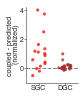

In [8]:
hfig,ax = create_fig_tuning()
sns.despine(hfig)
ax.hlines(0,-0.5,1.5,color = 'gray',lw = 1,linestyle='--')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-1,4.2)
ax.set_ylabel('coupled - predicted \n (normalized)',linespacing=0.75)
ax.set_xticklabels('')
sns.stripplot(y=(grc_df['c_epsp_amp']-grc_df['p_epsp_amp'])/grc_df['p_epsp_amp'],
              x = grc_df['cell_type'],
              palette = sns.color_palette(['red','brown']),
             jitter=0.25,alpha = 0.75,s = sqrt(10))
ax.set_xlabel('')
ax.set_xticklabels(['SGC','DGC'])
figsave(figure_folder,'Fig4_baseline_CDcoupleVpredict')

## coupled versus uncoupled ampshift

### SGC

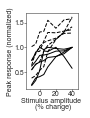

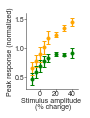

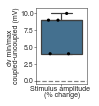

In [23]:
#superficial grc
# meta_df_uc = pd.read_csv('DF_update_sGRCPopulation_UncoupledAmpShift.csv')
# meta_df_c = pd.read_csv('DF_sGRCPopulation_CoupledAmpShift.csv')
meta_df_uc = pd.read_csv('DF_SGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv('DF_SGC_CoupledAmpShift_revised10Sept.csv')

R_ampshift_u = []
R_ampshift_norm_u = []
R_ampshift_c = []
R_ampshift_norm_c = []
for a in np.unique(meta_df_uc['exptname']):
    subdf = meta_df_uc[meta_df_uc['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_u.append(r)
    r_scale = np.max(r)
    r = r/r_scale
    R_ampshift_norm_u.append(r)
    
    subdf = meta_df_c[meta_df_c['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_c.append(r)
    r = r/r_scale
    R_ampshift_norm_c.append(r)
    
R_ampshift_u = np.asarray(R_ampshift_u)
R_ampshift_norm_sgrc_u = np.asarray(R_ampshift_norm_u)
R_ampshift_c = np.asarray(R_ampshift_c)
R_ampshift_norm_sgrc_c = np.asarray(R_ampshift_norm_c)
stim_ampshift = np.unique(meta_df_uc.ampshift)

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
# hfig = plt.figure(figsize = (4,6))
# ax = hfig.add_axes([0.2,0.2,0.7,0.7])
for expt_result in R_ampshift_norm_sgrc_u:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
for expt_result in R_ampshift_norm_sgrc_c:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='--',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
figsave(figure_folder,'Fig4_sgrcTuningCurves_UvC')

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
            yerr=stats.sem(R_ampshift_norm_sgrc_c[:,restrict_inds],0),linestyle="None",color = 'orange', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),color = 'orange',s = 10)
ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
            yerr=stats.sem(R_ampshift_norm_sgrc_u[:,restrict_inds],0),linestyle="None",color = 'green', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),color = 'green',s = 10)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_ylim(0.3,1.6)
sns.despine(hfig)
figsave(figure_folder,'Fig4_sgrcTuningCurves_UvC_mean')

dv_u = []
for r in R_ampshift_u:
    dv_u.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_c = np.asarray(dv_c).T


hfig,ax = create_fig_tuning()
sns.boxplot(y=np.round(dv_c - dv_u), whis=np.inf,saturation = 0.5,ax=ax)
ax.hlines(0,-1,1,linestyle = '--',color = 'gray')
sns.stripplot(y=np.round(dv_c - dv_u),s= sqrt(10),color = 'black',jitter = 0.4,ax=ax)
ax.set_ylabel('dv min/max \n coupled-uncoupled (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
figsave(figure_folder,'Fig4_sgrcTuningScatter_UvC')

In [24]:
print('uncoupled: mean mV change ' + str(np.round(np.mean(dv_u),1)) + ' sem ' + str(np.round(stats.sem(dv_u),1)))
print('coupled: mean mV change ' + str(np.round(np.mean(dv_c),1)) + ' sem ' + str(np.round(stats.sem(dv_c),1)))

uncoupled: mean mV change 8.7 sem 0.6
coupled: mean mV change 16.1 sem 1.6


### DGC

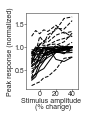

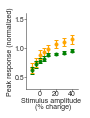

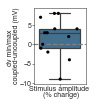

In [12]:
#deep grc
meta_df_uc = pd.read_csv('DF_DGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv('DF_DGC_CoupledAmpShift_revised10Sept.csv')
R_ampshift_u = []
R_ampshift_norm_u = []
R_ampshift_c = []
R_ampshift_norm_c = []
for a in np.unique(meta_df_uc['exptname']):
    subdf = meta_df_uc[meta_df_uc['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_u.append(r)
    r_scale = np.max(r)
    r = r/r_scale
    R_ampshift_norm_u.append(r)
    
    subdf = meta_df_c[meta_df_c['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_c.append(r)
    r = r/r_scale
    R_ampshift_norm_c.append(r)
    
R_ampshift_u = np.asarray(R_ampshift_u)
R_ampshift_norm_sgrc_u = np.asarray(R_ampshift_norm_u)
R_ampshift_c = np.asarray(R_ampshift_c)
R_ampshift_norm_sgrc_c = np.asarray(R_ampshift_norm_c)
stim_ampshift = np.unique(meta_df_uc.ampshift)

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
# hfig = plt.figure(figsize = (4,6))
# ax = hfig.add_axes([0.2,0.2,0.7,0.7])
for expt_result in R_ampshift_norm_sgrc_u:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
for expt_result in R_ampshift_norm_sgrc_c:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='--',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
figsave(figure_folder,'Fig4_dgrcTuningCurves_UvC')

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
            yerr=stats.sem(R_ampshift_norm_sgrc_c[:,restrict_inds],0),linestyle="None",color = 'orange', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),color = 'orange',s = 10)
ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
            yerr=stats.sem(R_ampshift_norm_sgrc_u[:,restrict_inds],0),linestyle="None",color = 'green', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),color = 'green',s = 10)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
ax.set_ylim(0.3,1.6)
sns.despine(hfig)
figsave(figure_folder,'Fig4_dgrcTuningCurves_UvC_mean')

dv_u = []
for r in R_ampshift_u:
    dv_u.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_c = np.asarray(dv_c).T


hfig,ax = create_fig_tuning()
sns.boxplot(y=np.round(dv_c - dv_u), whis=np.inf,saturation = 0.5,ax=ax)
ax.hlines(0,-1,1,linestyle = '--',color = 'gray')
sns.stripplot(y=np.round(dv_c - dv_u),s= sqrt(10),color = 'black',jitter = 0.4,ax=ax)
ax.set_ylabel('dv min/max \n coupled-uncoupled (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
figsave(figure_folder,'Fig4_dgrcTuningScatter_UvC')

In [19]:
print('uncoupled: mean mV change ' + str(np.round(np.mean(dv_u),1)) + ' sem ' + str(np.round(stats.sem(dv_u),1)))
print('coupled: mean mV change ' + str(np.round(np.mean(dv_c),1)) + ' sem ' + str(np.round(stats.sem(dv_c),1)))

mean mV change 10.734546693981205 sem 3.3387383770804395


### Output E

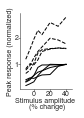

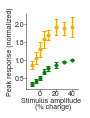

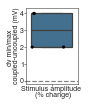

In [25]:
#Output E
meta_df_uc = pd.read_csv('DF_OutputEPopulation_SubUncoupledAmpShift.csv')
meta_df_c = pd.read_csv('DF_OutputPopulation_CoupledAmpShift.csv')
R_ampshift_u = []
R_ampshift_norm_u = []
R_ampshift_c = []
R_ampshift_norm_c = []
for a in np.unique(meta_df_uc['exptname']):
    subdf = meta_df_uc[meta_df_uc['exptname']==a].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift_u.append(r)
    r_scale = np.max(r)
    r = r/r_scale
    R_ampshift_norm_u.append(r)
    
    subdf = meta_df_c[meta_df_c['exptname']==a].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift_c.append(r)
    r = r/r_scale
    R_ampshift_norm_c.append(r)
    
R_ampshift_u = np.asarray(R_ampshift_u)
R_ampshift_norm_sgrc_u = np.asarray(R_ampshift_norm_u)
R_ampshift_c = np.asarray(R_ampshift_c)
R_ampshift_norm_sgrc_c = np.asarray(R_ampshift_norm_c)
stim_ampshift = np.unique(meta_df_uc.ampshift)

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
# hfig = plt.figure(figsize = (4,6))
# ax = hfig.add_axes([0.2,0.2,0.7,0.7])
for expt_result in R_ampshift_norm_sgrc_u:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
for expt_result in R_ampshift_norm_sgrc_c:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='--',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputTuningCurves_UvC')

restrict_inds = stim_ampshift>-20
hfig,ax = create_fig_tuning()
ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
            yerr=stats.sem(R_ampshift_norm_sgrc_c[:,restrict_inds],0),linestyle="None",color = 'orange', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),color = 'orange',s = 10)
ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
            yerr=stats.sem(R_ampshift_norm_sgrc_u[:,restrict_inds],0),linestyle="None",color = 'green', capsize=2)
ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),color = 'green',s = 10)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputTuningCurves_UvC_mean')

dv_u = []
for r in R_ampshift_u:
    dv_u.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_c = np.asarray(dv_c).T


hfig,ax = create_fig_tuning()
sns.boxplot(y=np.round(dv_c - dv_u), whis=np.inf,saturation = 0.5,ax=ax)
ax.hlines(0,-1,1,linestyle = '--',color = 'gray')
sns.stripplot(y=np.round(dv_c - dv_u),s= sqrt(10),color = 'black',jitter = 0.4,ax=ax)
ax.set_ylabel('dv min/max \n coupled-uncoupled (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
figsave(figure_folder,'Fig4_outputTuningScatter_UvC')

In [26]:
print('uncoupled: mean mV change ' + str(np.round(np.mean(dv_u),1)) + ' sem ' + str(np.round(stats.sem(dv_u),1)))
print('coupled: mean mV change ' + str(np.round(np.mean(dv_c),1)) + ' sem ' + str(np.round(stats.sem(dv_c),1)))

uncoupled: mean mV change 6.0 sem 1.4
coupled: mean mV change 8.8 sem 1.7


### example cells

#### SGC 20200718_000

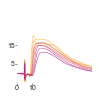

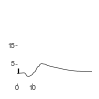

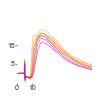

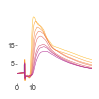

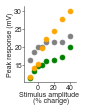

In [35]:
exptname = '20200718_000'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# bias -65
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0],
          expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample1_uncoupled')

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]

hfig,ax = create_fig()
ax.plot(xtime,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_grcExample1_cd')

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)

hfig,ax = create_fig()
# colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
# colinds = array([c for c in reversed(colinds)])
# trialmat = trialmat[:,restrict_inds]
# trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample1_predicted')

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample1_coupled')

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],color = 'green')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],color = 'gray')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],color = 'orange')
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_grcExample1_scatter')

#### DGC 20200719_004

/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr


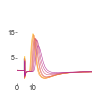

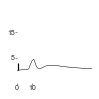

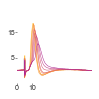

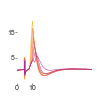

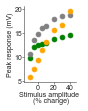

In [36]:
exptname = '20200719_004'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

#hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[3]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

sweepdur = 0.05
r_onset = int(0.006/dt)

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample2_uncoupled')

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]

hfig,ax = create_fig()
ax.plot(xtime,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_grcExample2_cd')

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)

hfig,ax = create_fig()
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample2_predicted')

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample2_coupled')

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],color = 'green')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],color = 'gray')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],color = 'orange')
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_grcExample2_scatter')



#### DGC 20200607_002

/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_002.smr


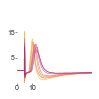

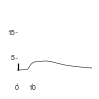

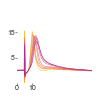

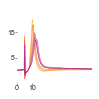

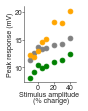

In [37]:
exptname = '20200607_002'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample3_uncoupled')

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]

hfig,ax = create_fig()
ax.plot(xtime,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_grcExample3_cd')

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)

hfig,ax = create_fig()
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample3_predicted')

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample3_coupled')

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],color = 'green')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],color = 'gray')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],color = 'orange')
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_grcExample3_scatter')



#### output cell 20200614_002 (_ampshift)

/Users/kperks/mnt/engram/spikedata/data_raw/20200614/20200614_002_ampshift.smr


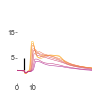

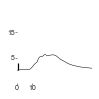

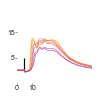

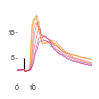

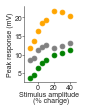

In [38]:
exptname = '20200614_002_ampshift'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
bout_cmd = [expt.get_bout_win('R','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

filtwin = int(0.002/dt)
if filtwin % 2 == 0:
    filtwin +=1

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
    R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample2_uncoupled')

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)

R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
cd_R = np.mean(R,1)


hfig,ax = create_fig()
ax.plot(xtime,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_outputcellExample2_cd')

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)

hfig,ax = create_fig()
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample2_predicted')

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
    R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample2_coupled')

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],color = 'green')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],color = 'gray')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],color = 'orange')
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputcellExample2_scatter')

#### output cell 20200712_000

/Users/kperks/mnt/engram/spikedata/data_raw/20200712/20200712_000.smr


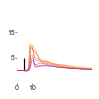

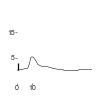

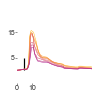

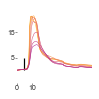

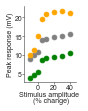

In [39]:
exptname = '20200712_000'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[6]]
bout_c = [expt.get_bout_win('N','Keyboard')[5]]
bout_cmd = [expt.get_bout_win("B","Keyboard")[2],expt.get_bout_win("B","Keyboard")[3]]

sweepdur = 0.05
r_onset = int(0.006/dt)

filtwin = int(0.003/dt)
if filtwin % 2 == 0:
    filtwin +=1

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
    R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample3_uncoupled')

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)

# trial_df = expt.filter_marker_df_code(bout_df,['U'])
# stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values - (0.005 - cd_offset)
# cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)

R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
cd_R = np.mean(R,1)

hfig,ax = create_fig()
ax.plot(xtime,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_outputcellExample3_cd')

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)

hfig,ax = create_fig()
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample3_predicted')

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
    R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample3_coupled')

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],color = 'green')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],color = 'gray')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],color = 'orange')
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputcellExample3_scatter')

#### output cell 20200107_004 (_ampshift2) *(coupled to Jlm)

/Users/kperks/mnt/engram/spikedata/data_raw/20200107/20200107_004_ampshift2.smr


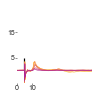

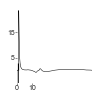

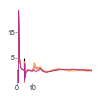

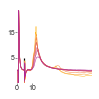

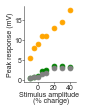

In [40]:
exptname = '20200107_004_ampshift2'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('K','Keyboard')[0]]
bout_cmd = [expt.get_bout_win('J','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

filtwin = int(0.002/dt)
if filtwin % 2 == 0:
    filtwin +=1

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
#     R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
# figsave(figure_folder,'Fig4_outputcellExample_uncoupled')

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['t'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['J'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)

# trial_df = expt.filter_marker_df_code(bout_df,['U'])
# stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['J'])
cd_t = trial_df.time.values - (0.005 - cd_offset)
# cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)

R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
# R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
cd_R = np.mean(R,1)

hfig,ax = create_fig()
ax.plot(xtime,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_outputcellExample_cd')

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)

hfig,ax = create_fig()
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample_predicted')

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['t'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['c'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
#     R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([0,10])
ax.set_yticks([5,15])
ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample_coupled')

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],color = 'green')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],color = 'gray')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],color = 'orange')
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputcellExample_scatter')

# Various supplemental

## MODEL DGC effects of cd inhib in dgrc (evoked like es inhib)

In [8]:
def initialize_model(namespace_sim):    
    start_scope()
    ################################################################################
    # Model definition
    ################################################################################
    IinjWav = namespace_sim['IinjWav']# TimedArray([0]*pA,dt=20*ms) #TimedArray([0,10,10,10,10,10,0]*pA,dt=20*ms) #
    invpeak = (namespace_sim['tau_e2'] / namespace_sim['tau_e1']) ** \
            (namespace_sim['tau_e1'] / (namespace_sim['tau_e2'] - namespace_sim['tau_e1']))
    namespace_sim['invpeak'] = invpeak
    ### Neurons
    neuron_eq = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_e_lmi*(E_e_lmi-v) + g_cd*(E_cd-v) + g_cd_i*(E_cd_i-v) + g_cd_lmi*(E_cd_lmi-v) + Iinj)/Cm    : volt (unless refractory)
    dg_e/dt = (invpeak * s - g_e)/tau_e1 : siemens
    ds/dt = -s/tau_e2 : siemens
    dg_e_lmi/dt = -g_e_lmi/tau_e_lmi  : siemens  # post-synaptic electrosensory inhibitory conductance
    dg_cd/dt = -g_cd/tau_cd : siemens  # post-synaptic CD excitatory conductance
    dg_cd_i/dt = -g_cd_i/tau_cd_i : siemens  # post-synaptic CD inhibitory conductance
    dg_cd_lmi/dt = -g_cd_lmi/tau_cd_lmi : siemens  # post-synaptic CD lmi-driven inhib conductance
    Iinj = IinjWav(t) : amp # injected current
    maxas = 3.5 : 1
    minas = 0 : 1
    midpt = 2 : 1
    slp = 3 : 1
    '''
        
    neurons = NeuronGroup(1, model=neuron_eq,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler',
                         name = 'grc',namespace=namespace_sim)
    neurons.v = namespace_sim['E_l']
    # set up monitor of post-synaptic neuron parameters
    state_mon = StateMonitor(neurons, ['v', 'g_e', 'g_cd','g_e_lmi','g_cd_i','g_cd_lmi','Iinj'], 
                             record=0, name = 'state_mon')
    
    ######### 
    #create and connect command input (direct and indirect via lmi)
    #########
    t_cd = array([namespace_sim['cmd_onset']])*ms
    t_cd_i = array([namespace_sim['cmd_i_onset']])*ms
    t_cd_lmi = array([namespace_sim['cmd_onset']+ namespace_sim['cmd_lmi_delay']])*ms
    G_cd = SpikeGeneratorGroup(1, array([0]), t_cd, name='jxl_input')
    G_cd_i = SpikeGeneratorGroup(1, array([0]), t_cd_i, name = 'cd_inhib_input')
    G_cd_lmi = SpikeGeneratorGroup(1, array([0]), t_cd_lmi, name = 'cd_lmi_input')
    #connect spike generator to neuron:
    syn_cd = Synapses(G_cd, neurons,on_pre='g_cd_post += w_cd',
                      name = 'jxl_syn',namespace=namespace_sim)
    syn_cd_i = Synapses(G_cd_i, neurons,on_pre='g_cd_i_post += w_cd_i',
                        name = 'cd_inhib_syn',namespace=namespace_sim)
    syn_cd_lmi = Synapses(G_cd_lmi, neurons,on_pre='g_cd_lmi_post += w_cd_lmi',
                          name = 'cd_lmi_syn',namespace=namespace_sim)
    #Now connect the synapses...
    syn_cd.connect(i=0,j=0)
    syn_cd_i.connect(i=0,j=0)
    syn_cd_lmi.connect(i=0,j=0)

    ######### 
    #create and connect afferent input (direct and indirect via lmi)
    #########
    aff_t_default = array(np.zeros(namespace_sim['N_inputs']))*ms
    N_aff = len(aff_t_default)
    neuron_ind = np.arange(N_aff)
    G_e = SpikeGeneratorGroup(N_aff, neuron_ind,aff_t_default,name='aff_input')
    G_e_lmi = SpikeGeneratorGroup(1, array([0]),array([0])*ms,name = 'aff_lmi_input')
    #connect spike generator to neuron:
    syn_e = Synapses(G_e, neurons,on_pre='s += w_e',name='aff_syn',namespace=namespace_sim)
    syn_e_lmi = Synapses(G_e_lmi, neurons,on_pre='g_e_lmi_post += \
                         w_e_lmi*(maxas+((minas-maxas)/(1+(((v-E_l)/mV)/midpt)**slp)))*nS',
                         delay=namespace_sim['e_lmi_delay']*ms,
                      name='aff_lmi_syn',namespace=namespace_sim)

    #Now connect the synapses...
    syn_e.connect(i=neuron_ind, j = 0)
    syn_e_lmi.connect(i=0, j = 0)

    net = Network(collect())
    return net, namespace_sim

def reset_namespace_defaults():
    namespace_sim = {
        'N_inputs' : 1,
        'N_runs' : 1,
        'sim_dt' : 0.1*ms,
        'duration' : 0.05*second,
        'Cm' : 6*pF,
        'E_l' : -70*mV,
        'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
        'E_e' : 0*mV,
        'E_cd' : 0*mV,
        'E_cd_i' : -80*mV,
        'E_cd_lmi' : -80*mV,
        'E_e_lmi' : -80*mV,
        'V_th' : 0*mV,
        'V_r' : -70*mV,
        'tau_r' : 1*ms,
        'w_e' : 0*nS,
        'w_e_lmi' : 0,#either on and off... weight by logistic 0*nS,
        'w_cd' : 0*nS,
        'w_cd_i' : 0*nS,
        'w_cd_lmi' : 0*nS,  
        'tau_e1' : 4*ms,
        'tau_e2' : 1*ms,
        'tau_e_lmi' : 10*ms,
        'tau_cd' : 2*ms,
        'tau_cd_i' : 5*ms,
        'tau_cd_lmi' : 5*ms,
        'cmd_onset' : 5, #ms
        'cmd_i_onset' : 4.5,
        'cmd_lmi_delay' : 4, #ms
        'aff_cmd_offset' : 5, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5, #ms, time of normal stimulus onset relative to cmd
        'e_lmi_delay' : 2, #ms
        'IinjWav' : TimedArray([0]*pA,dt=20*ms),
        'invpeak' : 1
    }
    return namespace_sim

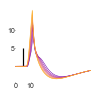

In [61]:
x = np.asarray([-10,-5,0,5,10,20,30,40])

namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 6*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_runs'] = 15
namespace_sim['N_inputs'] = 8
namespace_sim['w_e_lmi'] = 1
namespace_sim['e_lmi_delay'] = 2

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_wavs)[1]))

for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
R_deep_inhib = np.asarray([r for r in R_amp.T]).T
R_norm_deep_inhib = np.asarray([r/np.max(r) for r in R_amp.T]).T

In [9]:
exptname = '20200719_004'
boutstr = '''[expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1],
            expt.get_bout_win('N','Keyboard')[0]]'''
sweepdur = 0.05
# xtime_cmd_inh, cmd_inh_ = get_example_cmd(exptname,boutstr,sweepdur)

filepath = Path.cwd() / 'grc_model_simulations' / (exptname + '_cmd.npy')
# stacked_arr = np.stack([xtime_cmd,cmd_])
# np.save(filepath,stacked_arr)
stacked_arr = np.load(filepath)
xtime_cmd_inh = stacked_arr[0,:]
cmd_inh_ = stacked_arr[1,:]

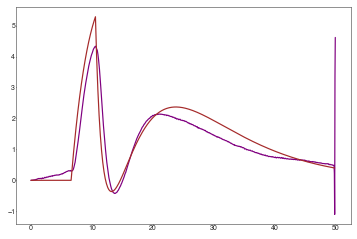

In [40]:
plt.figure()

plt.plot(xtime_cmd_inh,cmd_inh_,color = 'purple')

aff_t = [2]

namespace_sim = reset_namespace_defaults()
namespace_sim['N_inputs'] = 1
namespace_sim['Cm'] = 6*pF
namespace_sim['w_cd'] = 0.2*nS
namespace_sim['tau_cd'] = 10*ms
namespace_sim['w_cd_lmi'] = 3*nS
namespace_sim['tau_cd_lmi'] = 2*ms
namespace_sim['cmd_onset'] = 6.5
namespace_sim['cmd_lmi_delay'] = 4

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)
xtime,R = model_single_run(net,namespace_sim,sim_filepath,aff_t)
plt.plot(xtime,(R-R[0]),color = 'brown',linestyle = '-')

# figsave(figure_folder,'Fig4_deep_cd_stronginhib_modelVScell')

cmd_inh_model = R
xtime_cmd_inh_model = xtime

In [62]:
namespace_sim = reset_namespace_defaults()

namespace_sim['Cm'] = 6*pF
namespace_sim['w_e'] = 0.1*nS
namespace_sim['N_runs'] = 15
namespace_sim['N_inputs'] = 8
namespace_sim['w_e_lmi'] = 1
namespace_sim['e_lmi_delay'] = 2

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

R_amp_predict = []
for i in range(15):
    net.restore('intialized',filename=sim_filepath)
    xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)
    r_amp_predict = []
    for sweep in R_wavs.T:
        R_predict = sweep+cmd_inh_model
#         plt.plot(xtime_cmd_inh_model,R_predict)
        r_amp_predict.append(np.max(sweep))
    r_amp_predict = np.asarray(r_amp_predict).T
    R_amp_predict.append(r_amp_predict)
R_amp_predict = np.asarray(R_amp_predict).T
R_amp_predict = np.asarray([r for r in R_amp_predict.T]).T
R_amp_predict_norm = np.asarray([r/np.max(r) for r in R_amp_predict.T]).T

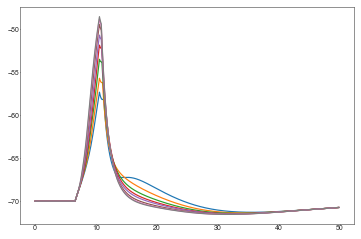

In [63]:
for sweep in R_wavs.T:
    R_predict = sweep+cmd_inh_model
    plt.plot(xtime_cmd_inh_model,R_predict)

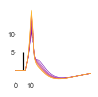

In [64]:
namespace_sim['w_cd'] = 0.2*nS
namespace_sim['tau_cd'] = 10*ms
namespace_sim['w_cd_lmi'] = 3*nS
namespace_sim['tau_cd_lmi'] = 2*ms
namespace_sim['cmd_onset'] = 6.5
namespace_sim['cmd_lmi_delay'] = 4

net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)

xtime,R_wavs = example_ampshift_wavs(x,net,namespace_sim,sim_filepath)

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,np.shape(R_wavs)[1]))

for i,sweep in enumerate(R_wavs.T):
    ax.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_xticks([0,10])
ax.set_yticks([5,10])
ax.vlines(5,0,5)

x, R_amp = model_ampshift(x,net,namespace_sim,sim_filepath)
R_deep_inhib_CD = np.asarray([r for r in R_amp.T]).T
R_norm_deep_inhib_CD = np.asarray([r/np.max(r) for r in R_amp.T]).T

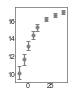

In [73]:
hfig,ax = create_fig_tuning()

plt.errorbar(x,np.mean(R_amp_predict,1),yerr=stats.sem(R_amp_predict,1),linestyle="None",color = 'gray', capsize=2)
ax.scatter(x,np.mean(R_amp_predict,1),color = 'gray',s=10)

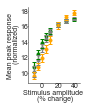

In [74]:
hfig,ax = create_fig_tuning()

plt.errorbar(x,np.mean(R_deep_inhib,1),yerr=stats.sem(R_deep_inhib,1),linestyle="None",color = 'green', capsize=2)
ax.scatter(x,np.mean(R_deep_inhib,1),color = 'green',s=10)
plt.errorbar(x,np.mean(R_amp_predict,1),yerr=stats.sem(R_amp_predict,1),linestyle="None",color = 'gray', capsize=2)
ax.scatter(x,np.mean(R_amp_predict,1),color = 'gray',s=10)
plt.errorbar(x,np.mean(R_deep_inhib_CD,1),yerr=stats.sem(R_deep_inhib_CD,1),linestyle="None",color = 'orange', capsize=2)
ax.scatter(x,np.mean(R_deep_inhib_CD,1),color = 'orange',s=10)

ax.set_ylabel('Mean peak response \n (normalized)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
# plt.ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Fig4_deep_norm_cdVSnot')

### and with less striking inhibition...

In [84]:
exptname = '20191218_009'
sweepdur = 0.05
boutstr = '''[expt.get_bout_win('R','Keyboard')[0],
        expt.get_bout_win('R','Keyboard')[1],
        expt.get_bout_win('N','Keyboard')[0],
        expt.get_bout_win('N','Keyboard')[1]]'''

# xtime_cmd, cmd_ = get_example_cmd(exptname,boutstr,sweepdur)
filepath = Path.cwd() / 'grc_model_simulations' / (exptname + '_cmd.npy')
# stacked_arr = np.stack([xtime_cmd,cmd_])
# np.save(filepath,stacked_arr)
stacked_arr = np.load(filepath)
xtime_cmd = stacked_arr[0,:]
cmd_ = stacked_arr[1,:]


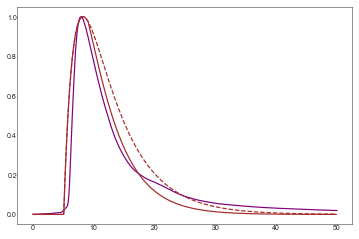

In [85]:
plt.plot(xtime_cmd,cmd_/np.max(cmd_),color = 'purple')

namespace_sim = reset_namespace_defaults()
namespace_sim['N_inputs'] = 1
namespace_sim['w_cd'] = 0.4*nS
namespace_sim['Cm'] = 6*pF
net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)
xtime,R = model_single_run(net,namespace_sim,sim_filepath,aff_t)

plt.plot(xtime,(R-R[0])/np.max(R-R[0]),color = 'brown',linestyle = '--')

namespace_sim['w_cd_lmi'] = 0.15*nS
namespace_sim['cmd_lmi_delay'] = 4
net, namespace_sim = initialize_model(namespace_sim)
net.store('intialized',filename=sim_filepath)
xtime,R = model_single_run(net,namespace_sim,sim_filepath,aff_t)
plt.plot(xtime,(R-R[0])/np.max(R-R[0]),color = 'brown',linestyle = '-')

## import GC properties dataframe and adjust Vm vals based on offset, etc

In [ ]:
#@title import dataframe for GRC bais properties quantifications 
df_folder = exptpath / 'data_processed' / 'Figures_GRC_properties' / 'Unsubtracted_CvsU' / 'df_cmdintact'
path = df_folder
files = [e for e in path.iterdir() if e.is_file() and e.suffix=='.csv']
keys = [f.name[0:-4] for f in sorted(files)]

meta_df = pd.DataFrame(columns = None)
for f in files:
    thisdf = pd.read_csv(f)
    meta_df = meta_df.append(thisdf,ignore_index = True)
meta_df['cell_type'] = meta_df['exptname'].map(cell_type)

#create new column with Vm_baseline adjusted based on Vm_offset manually measured from each recording
for name, val in Vm_offset.items():
#     print(name,val)
    adjusted_val = meta_df[meta_df['exptname'].str.contains(name)]['Vm_baseline'] + val
    meta_df.loc[meta_df['exptname'].str.contains(name),'Vm_base_adj'] = adjusted_val

#create new column with Vm_baseline adjusted based on Vm_offset manually measured from each recording
for name, val in Vm_offset.items():
    meta_df.loc[meta_df['exptname'].str.contains(name),'Vm_offset'] = val

#remove estim ipsp from superficial cells because erroneous (not true inhibition... just algorithm glitch)
meta_df.loc[meta_df['cell_type'] == 's', 'u_ipsp_onset'] = np.NaN
meta_df.loc[meta_df['cell_type'] == 's', 'c_ipsp_onset'] = np.NaN

meta_df = meta_df.set_index('exptname',append=False)

## Afferents population properties all fish

In [172]:
p_active=[]
for i,animal in enumerate(np.unique(filtered_df['animalID'])):
    animal_df = filtered_df[filtered_df['animalID'] == animal]

    n_active = []
    for a in np.unique(animal_df['ampshift']):
        subdf = animal_df[animal_df['ampshift']==a].groupby('exptname')
        n_active.append(len(np.where(subdf.fsl.count().values>0)[0]))
    n_active = np.asarray(n_active)

    ntotal = len(subdf.fsl.count())
    p_active.append(100*(n_active/ntotal))

In [174]:
np.mean(p_active,0)

array([ 23.03030303,  48.87445887,  84.15584416,  94.39393939,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        ])

In [169]:
p_active=[]

n_active = []
for a in np.unique(filtered_df['ampshift']):
    subdf = filtered_df[filtered_df['ampshift']==a].groupby('exptname')
    n_active = len(np.where(subdf.fsl.count().values>0)[0])
    ntotal = len(subdf.fsl.count())
    p_active.append(100*(n_active/ntotal))



In [170]:
p_active

[22.22222222222222,
 48.148148148148145,
 81.48148148148148,
 94.44444444444444,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

20200129(blue) has a total of 11 afferents recorded
20200204(orange) has a total of 11 afferents recorded
20200531(brown) has a total of 27 afferents recorded
20200621(green) has a total of 15 afferents recorded
number afferents excluded because first fsl threshold too high or could not be fit: 3
number afferents included (spike thresh at least 0%): 61
        exptname    animal   stretch       tau    offset    max_fsl  \
1   20200129_003  20200129  5.002921 -0.017816  1.000000   9.532944   
4   20200129_006  20200129  5.715809 -0.022154  1.000000   9.858215   
7   20200129_009  20200129  5.451725 -0.015384  1.000000   9.357798   
10  20200129_012  20200129  6.623366 -0.019459  1.000000  12.010008   
1   20200531_001  20200531  6.964934 -0.020705  1.000000  11.347565   
7   20200531_007  20200531  3.842939 -0.038101  2.673761  11.087392   

           sse   df  
1   103.435863   94  
4    48.310496  108  
7    43.739012   40  
10   91.976468   85  
1    56.609527  105  
7   109.099794 

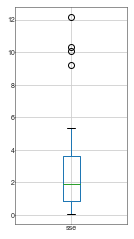

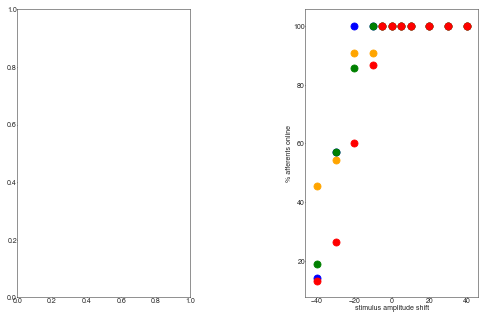

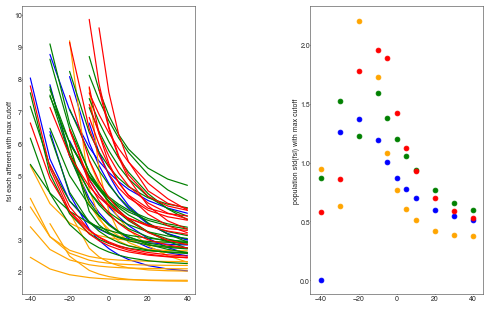

In [160]:
hfig = plt.figure(figsize=(8,5))
ax1 = hfig.add_axes([0.1,0.1,0.3,0.8])
ax2 = hfig.add_axes([0.6,0.1,0.3,0.8])
ax2.set_ylabel('% afferents online')
ax2.set_xlabel('stimulus amplitude shift')
colors = ['blue','orange','green','red']
# animal = np.unique(well_fit['animal'])[2]

for i,animal in enumerate(np.unique(filtered_df['animalID'])):
    animal_df = filtered_df[filtered_df['animalID'] == animal]

    n_active = []
    for a in np.unique(animal_df['ampshift']):
        subdf = animal_df[animal_df['ampshift']==a].groupby('exptname')
        n_active.append(len(np.where(subdf.fsl.count().values>0)[0]))
    n_active = np.asarray(n_active)

    ntotal = len(subdf.fsl.count())
    ax2.scatter(np.unique(animal_df['ampshift']),100*(n_active/ntotal),
               color=colors[i],s=50)

hfig = plt.figure(figsize=(8,5))
ax1 = hfig.add_axes([0.1,0.1,0.3,0.8])
ax2 = hfig.add_axes([0.6,0.1,0.3,0.8])
x = [-40,-30,-20,-10,-5,0,5,10,20,30,40]
# animal = np.unique(well_fit['animal'])[2]
for i,animal in enumerate(np.unique(filtered_df['animalID'])):
    animal_df = well_fit[well_fit['animal'] == animal]
    y_fit = []
    y_fit_ext = []

    for name in np.unique(animal_df['exptname']):
        expt_df = animal_df[animal_df['exptname'] == name]
        y = exp_fit(x,expt_df['stretch'].values,expt_df['tau'].values,expt_df['offset'].values)
        y[y>expt_df['max_fsl'].values] = np.NaN
        y_ext = exp_fit(x,expt_df['stretch'].values,expt_df['tau'].values,expt_df['offset'].values)  

        y_fit.append(y)
        y_fit_ext.append(y_ext)

    y_fit = np.asarray(y_fit).T
    y_fit_ext = np.asarray(y_fit_ext).T

    ax1.plot(x,y_fit,color = colors[i]);
    ax1.set_ylabel('fsl each afferent with max cutoff')
    ax2.scatter(x,np.nanstd(y_fit,1),color = colors[i]);
    ax2.set_ylabel('population std(fsl) with max cutoff')


  

## preservation of latency code preserved in peak response time

### SGC

In [9]:
all_exptname_uc = {
    '20200718_000' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200606_001' : '[expt.get_bout_win("R","Keyboard")[1]]',
    '20200607_000' : '[expt.get_bout_win("R","Keyboard")[1],expt.get_bout_win("R","Keyboard")[2]]',
    '20200524_002' : '[expt.get_bout_win("R","Keyboard")[1]]',
    '20200109_004' : '[expt.get_bout_win("R","Keyboard")[2]]'
#     '20200607_003' : '[expt.get_bout_win('R',"Keyboard")[0]]' is this an sGRC?
}

In [10]:
# save array of uncoupled avg for each cell as a dictionary entry...
# then save dictionary
sweepdur = 0.1
wavmat = {}
meta_df = pd.DataFrame()
for exptname,boutstr in all_exptname_uc.items():
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)

    expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    
    bout_uc = eval(boutstr)
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    min_peakt = 0.002 #(s)
    threshold_h = 1 #(mV)
    subsweepdur = 0.05
    dt = expt.get_dt('lowgain')

    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    peakAmp = []
    peakT = []
    sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
    xtime = xtime[int(min_peakt/dt):]
    for sweep in sweeps.T:
        peakAmp.append(sweep[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]>=threshold_h:
            peakT.append(xtime[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]<threshold_h:
            peakT.append(np.NaN)
        
    trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
    trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
    meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)
    
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    wavmat[exptname] = trialmat


/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200524/20200524_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200109/20200109_004.smr


In [14]:
pickle_out = open(df_folder / 'SGC_uncoupled_wavmat.pickle','wb')
pickle.dump(wavmat, pickle_out)
pickle_out.close()

meta_df.to_csv('DF_SGC_UncoupledAmpShift_revised10Sept.csv')


### DGC

In [98]:
all_exptname_uc = {
    '20200719_004' : '[expt.get_bout_win("R","Keyboard")[3]]',
    '20200719_001' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200606_005' : '[expt.get_bout_win("R","Keyboard")[1]]',
    '20200607_005' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200607_004' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200607_002' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200525_001' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200525_006' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200312_002' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200227_000' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200226_002' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200225_000' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200115_002' : '[expt.get_bout_win("R","Keyboard")[0]]'
}

In [99]:
# save array of uncoupled avg for each cell as a dictionary entry...
# then save dictionary
sweepdur = 0.1
wavmat = {}
meta_df = pd.DataFrame()
for exptname,boutstr in all_exptname_uc.items():
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)

    expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    
    bout_uc = eval(boutstr)
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    min_peakt = 0.002 #(s)
    threshold_h = 1 #(mV)
    subsweepdur = 0.05
    dt = expt.get_dt('lowgain')

    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    peakAmp = []
    peakT = []
    sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
    xtime = xtime[int(min_peakt/dt):]
    for sweep in sweeps.T:
        peakAmp.append(sweep[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]>=threshold_h:
            peakT.append(xtime[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]<threshold_h:
            peakT.append(np.NaN)
        
    trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
    trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
    meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)
    
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    wavmat[exptname] = trialmat


/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_005.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_005.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_004.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_006.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200312/20200312_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200227/20200227_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200226/20200226_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200225/20200225_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200115/20200115_002.smr


In [100]:
pickle_out = open(df_folder / 'DGC_uncoupled_wavmat.pickle','wb')
pickle.dump(wavmat, pickle_out)
pickle_out.close()

meta_df.to_csv('DF_DGC_UncoupledAmpShift_revised10Sept.csv')


### aferents

20200129(blue) has a total of 11 afferents recorded
20200204(orange) has a total of 11 afferents recorded
20200531(brown) has a total of 27 afferents recorded
20200621(green) has a total of 15 afferents recorded
number afferents excluded because first fsl threshold too high or could not be fit: 3
number afferents included (spike thresh at least 0%): 61
        exptname    animal   stretch       tau    offset    max_fsl  \
1   20200129_003  20200129  5.002921 -0.017816  1.000000   9.532944   
4   20200129_006  20200129  5.715809 -0.022154  1.000000   9.858215   
7   20200129_009  20200129  5.451725 -0.015384  1.000000   9.357798   
10  20200129_012  20200129  6.623366 -0.019459  1.000000  12.010008   
1   20200531_001  20200531  6.964934 -0.020705  1.000000  11.347565   
7   20200531_007  20200531  3.842939 -0.038101  2.673761  11.087392   

           sse   df  
1   103.435863   94  
4    48.310496  108  
7    43.739012   40  
10   91.976468   85  
1    56.609527  105  
7   109.099794 

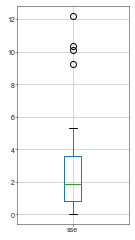

In [49]:
exptdate = 'all'
# meta_df.to_csv('DF_AfferentPopulation_' + exptdate + '.csv')
meta_df = pd.read_csv('DF_AfferentPopulation_' + exptdate + '.csv')

meta_params_df,expt_excluded = exclude_HighThreshAff(meta_df)

well_fit,un_fit = assess_fits(meta_params_df)

# meta_params_df = meta_params_df.dropna()
data_df = well_fit
dataset = list(zip(
    data_df['stretch'],
    data_df['tau'],
    data_df['offset'],
    data_df['max_fsl']
    ))
dataset = np.asarray(dataset)
# dataset = dataset[:,0:3]

rv = gaussian_kde(dataset[:,0:3].T)

max_fsl_global = np.max(meta_params_df['max_fsl'])

# plot_corr_matrix_multigauss(rv)
# filtered_df = meta_df[meta_df.exptname.str.match('|'.join(well_fit.exptname.values))]

### plot GC and afferent populations together mean/sem

WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
 [py.warnings]


afferent tuning: mean ms change -2.0 sem 0.2


WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
 [py.warnings]


DGC tuning: mean ms change -2.6 sem 0.4
SGC tuning: mean ms change -3.8 sem 1.1


WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
 [py.warnings]
WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: Mean of empty slice
 [py.warnings]
WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice
 [py.warnings]
WARNING    /anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice
 [py.warnings]


MF tuning: mean ms change -1.6 sem 0.2


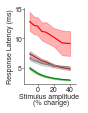

In [33]:

hfig,ax = create_fig_tuning()

x = array([-40,-30,-20,-10,-5,0,5,10,20,30,40])

restrict_inds = x>-20

y_fit = []
for i,animal in enumerate(np.unique(data_df['animal'])):
    animal_df = data_df[data_df['animal'] == animal]
    for name in np.unique(animal_df['exptname']):
        expt_df = animal_df[animal_df['exptname'] == name]
        y = exp_fit(x,expt_df['stretch'].values,expt_df['tau'].values,expt_df['offset'].values)
        y[y>11] = np.NaN
        y_fit.append(y)
y_fit = np.asarray(y_fit).T

ax.plot(x[restrict_inds],np.nanmean(y_fit,1)[restrict_inds],color = 'green');
ax.fill_between(x[restrict_inds],
                np.nanmean(y_fit,1)[restrict_inds]-stats.sem(y_fit,1,nan_policy='omit')[restrict_inds],
                np.nanmean(y_fit,1)[restrict_inds]+stats.sem(y_fit,1,nan_policy='omit')[restrict_inds],
               color='green',alpha=0.3)

dt_aff = []
for r in y_fit.T:
    dt_aff.append(r[restrict_inds][-1] - r[restrict_inds][0])
dt_aff = np.asarray(dt_aff).T
                

print('afferent tuning: mean ms change ' + str(np.round(np.nanmean(dt_aff),1)) + ' sem ' 
      + str(np.round(stats.sem(dt_aff,nan_policy='omit'),1)))




##########
meta_df = pd.read_csv('DF_DGC_UncoupledAmpShift_revised10Sept.csv')
pop_peakT = []
for name in np.unique(meta_df['exptname']):
    exptdf = meta_df[meta_df['exptname']==name]
    peakT = []
    for a in np.unique(exptdf.ampshift):
        peakT.append(np.nanmean(exptdf[exptdf['ampshift']==a].peakT))
    peakT = np.asarray(peakT).T
    pop_peakT.append(peakT)
pop_peakT = np.asarray(pop_peakT).T

ax.plot(x[restrict_inds],np.nanmean(pop_peakT,1)[restrict_inds],color = 'brown');

ax.fill_between(x[restrict_inds],
                np.nanmean(pop_peakT,1)[restrict_inds]-stats.sem(pop_peakT,1)[restrict_inds],
                np.nanmean(pop_peakT,1)[restrict_inds]+stats.sem(pop_peakT,1)[restrict_inds],
               color='brown',alpha=0.3)

dt_DGC = []
for r in pop_peakT.T:
    dt_DGC.append(r[restrict_inds][-1] - r[restrict_inds][0])
dt_DGC = np.asarray(dt_DGC).T

print('DGC tuning: mean ms change ' + str(np.round(np.nanmean(dt_DGC),1)) + ' sem ' 
      + str(np.round(stats.sem(dt_DGC,nan_policy='omit'),1)))

##########
meta_df = pd.read_csv('DF_SGC_UncoupledAmpShift_revised10Sept.csv')
pop_peakT = []
for name in np.unique(meta_df['exptname']):
    exptdf = meta_df[meta_df['exptname']==name]
    peakT = []
    for a in np.unique(exptdf.ampshift):
        peakT.append(np.nanmean(exptdf[exptdf['ampshift']==a].peakT))
    peakT = np.asarray(peakT).T
    pop_peakT.append(peakT)
pop_peakT = np.asarray(pop_peakT).T

ax.plot(x[restrict_inds],np.nanmean(pop_peakT,1)[restrict_inds],color = 'red');

ax.fill_between(x[restrict_inds],
                np.nanmean(pop_peakT,1)[restrict_inds]-stats.sem(pop_peakT,1)[restrict_inds],
                np.nanmean(pop_peakT,1)[restrict_inds]+stats.sem(pop_peakT,1)[restrict_inds],
               color='red',alpha=0.3)

dt_SGC = []
for r in pop_peakT.T:
    dt_SGC.append(r[restrict_inds][-1] - r[restrict_inds][0])
dt_SGC = np.asarray(dt_SGC).T

print('SGC tuning: mean ms change ' + str(np.round(np.nanmean(dt_SGC),1)) + ' sem ' 
      + str(np.round(stats.sem(dt_SGC,nan_policy='omit'),1)))

# ##########
meta_df = pd.read_csv('DF_MFPopulation_UncoupledAmpShift.csv')
pop_peakT = []
for name in np.unique(meta_df['exptname']):
    exptdf = meta_df[meta_df['exptname']==name]
    peakT = []
    for a in np.unique(exptdf.ampshift):
        peakT.append(np.nanmean(exptdf[exptdf['ampshift']==a].fsl))
    peakT = np.asarray(peakT).T
    pop_peakT.append(peakT)
pop_peakT = np.asarray(pop_peakT).T

ax.plot(x[restrict_inds],np.nanmean(pop_peakT,1)[restrict_inds],color = 'gray');

ax.fill_between(x[restrict_inds],
                np.nanmean(pop_peakT,1)[restrict_inds]-stats.sem(pop_peakT,1)[restrict_inds],
                np.nanmean(pop_peakT,1)[restrict_inds]+stats.sem(pop_peakT,1)[restrict_inds],
               color='gray',alpha=0.3)

dt_MF = []
for r in pop_peakT.T:
    dt_MF.append(r[restrict_inds][-1] - r[restrict_inds][0])
dt_MF = np.asarray(dt_MF).T

print('MF tuning: mean ms change ' + str(np.round(np.nanmean(dt_MF),1)) + ' sem ' 
      + str(np.round(stats.sem(dt_MF,nan_policy='omit'),1)))

ax.set_ylabel('Response Latency (ms)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
# plt.ylim(0.3,1.05)
sns.despine(hfig)
figsave(figure_folder,'Supp_PopMean_LatencyShift')

# re-do sgrc and dgrc coupled

In [105]:
#DGC
all_exptname_c = {
    '20200719_004' : '[expt.get_bout_win("N","Keyboard")[1]]',
    '20200719_001' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200606_005' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200607_005' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200607_004' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200607_002' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200525_001' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200525_006' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200312_002' : '[expt.get_bout_win("N","Keyboard")[0],expt.get_bout_win("N","Keyboard")[1]]',
    '20200227_000' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200226_002' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200225_000' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200115_002' : '[expt.get_bout_win("N","Keyboard")[0]]'
}

In [106]:
# save array of uncoupled avg for each cell as a dictionary entry...
# then save dictionary
sweepdur = 0.1
wavmat = {}
meta_df = pd.DataFrame()
for exptname,boutstr in all_exptname_c.items():
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)

    expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    
    bout_uc = eval(boutstr)
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    min_peakt = 0.002 #(s)
    threshold_h = 1 #(mV)
    subsweepdur = 0.05
    dt = expt.get_dt('lowgain')

    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    peakAmp = []
    peakT = []
    sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
    xtime = xtime[int(min_peakt/dt):]
    for sweep in sweeps.T:
        peakAmp.append(sweep[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]>=threshold_h:
            peakT.append(xtime[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]<threshold_h:
            peakT.append(np.NaN)
        
    trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
    trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
    meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)
    
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    wavmat[exptname] = trialmat


/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_005.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_005.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_004.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_006.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200312/20200312_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200227/20200227_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200226/20200226_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200225/20200225_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200115/20200115_002.smr


In [107]:
pickle_out = open(df_folder / 'DGC_coupled_wavmat.pickle','wb')
pickle.dump(wavmat, pickle_out)
pickle_out.close()

meta_df.to_csv('DF_DGC_CoupledAmpShift_revised10Sept.csv')

In [108]:
#SGC
all_exptname_c = {
    '20200718_000' : '[expt.get_bout_win("N","Keyboard")[0]]',
    '20200606_001' : '[expt.get_bout_win("N","Keyboard")[1]]',
    '20200607_000' : '[expt.get_bout_win("N","Keyboard")[1],expt.get_bout_win("N","Keyboard")[2]]',
    '20200524_002' : '[expt.get_bout_win("N","Keyboard")[1]]',
    '20200109_004' : '[expt.get_bout_win("N","Keyboard")[1]]'
}

In [109]:
# save array of uncoupled avg for each cell as a dictionary entry...
# then save dictionary
sweepdur = 0.1
wavmat = {}
meta_df = pd.DataFrame()
for exptname,boutstr in all_exptname_c.items():
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)

    expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    
    bout_uc = eval(boutstr)
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    min_peakt = 0.002 #(s)
    threshold_h = 1 #(mV)
    subsweepdur = 0.05
    dt = expt.get_dt('lowgain')

    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    peakAmp = []
    peakT = []
    sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
    xtime = xtime[int(min_peakt/dt):]
    for sweep in sweeps.T:
        peakAmp.append(sweep[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]>=threshold_h:
            peakT.append(xtime[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]<threshold_h:
            peakT.append(np.NaN)
        
    trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
    trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
    meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)
    
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    wavmat[exptname] = trialmat


/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200524/20200524_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200109/20200109_004.smr


In [110]:
pickle_out = open(df_folder / 'SGC_coupled_wavmat.pickle','wb')
pickle.dump(wavmat, pickle_out)
pickle_out.close()

meta_df.to_csv('DF_SGC_CoupledAmpShift_revised10Sept.csv')